In [1]:
import os
import shutil

import warnings
from rdkit import RDLogger
# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')


base_path = os.getcwd()

parent_path = os.path.dirname(os.path.dirname(base_path))

fig_path = os.path.join(parent_path, "figures")
gae_data_path = os.path.join(fig_path, "ARGVA")
if os.path.exists(gae_data_path):
    shutil.rmtree(gae_data_path)
    print(f"Deleted folder: {gae_data_path}")
else:
    print(f"Folder does not exist: {gae_data_path}")

os.makedirs(fig_path, exist_ok=True)


os.makedirs(gae_data_path, exist_ok=True)

Deleted folder: c:\Users\sarab\OneDrive\Desktop\CSIR\generative_model_compare\figures\ARGVA


Starting visualization...
Loading files...
Columns in first file: ['SMILE', 'frag_likeliness']
Columns in second file: ['SMILE', 'frag_likeliness']
Using column 'SMILE' for first file and 'SMILE' for second file
Processing 1525 molecules from file 1 and 1611 molecules from file 2...
Successfully processed 1525 and 1611 valid molecules
Generating Morgan fingerprints...
Performing PCA...
Performing t-SNE...


  File "c:\Users\sarab\miniconda3\envs\ENV4\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Performing MDS...
Calculating similarity matrix...
Calculating pairwise similarities...


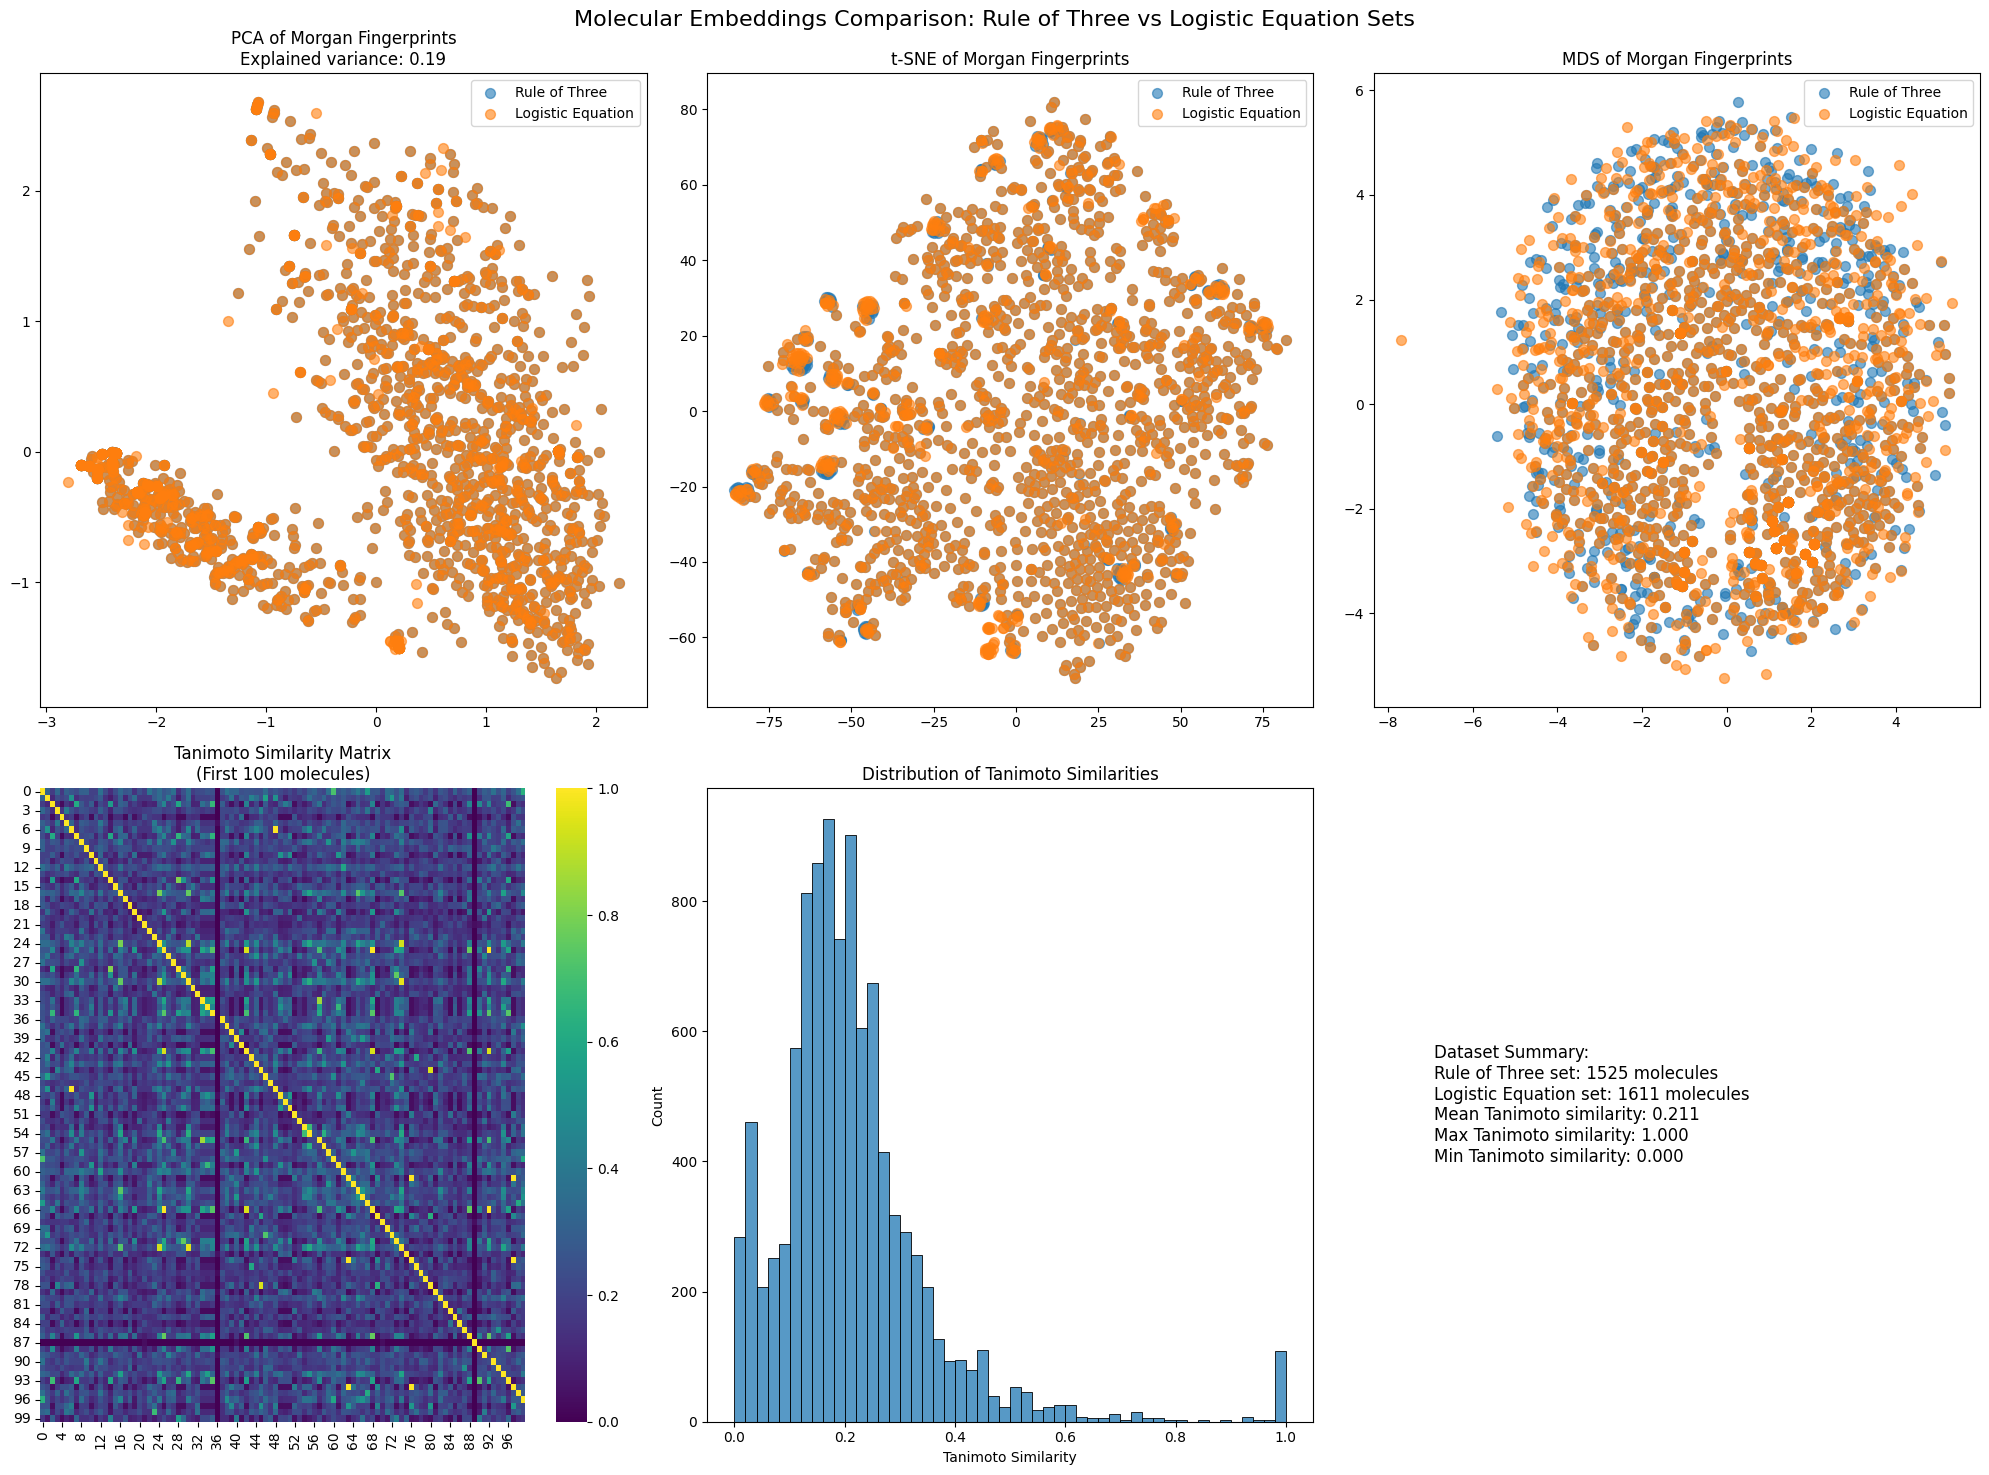

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

def visualize_all_embeddings(file1_path: str, file2_path: str):
    """
    Generate and visualize multiple types of molecular embeddings
    """
    
    print("Loading files...")
    df1 = pd.read_csv(file1_path)
    df2 = pd.read_csv(file2_path)
    
    
    print("Columns in first file:", df1.columns.tolist())
    print("Columns in second file:", df2.columns.tolist())
    
    
    smiles_col1 = 'SMILES' if 'SMILES' in df1.columns else 'SMILE'
    smiles_col2 = 'SMILES' if 'SMILES' in df2.columns else 'SMILE'
    
    print(f"Using column '{smiles_col1}' for first file and '{smiles_col2}' for second file")
    print(f"Processing {len(df1)} molecules from file 1 and {len(df2)} molecules from file 2...")
    
    
    mols1 = []
    mols2 = []
    
    
    for smiles in df1[smiles_col1]:
        try:
            if pd.notna(smiles):  
                mol = Chem.MolFromSmiles(str(smiles))
                if mol is not None:
                    mols1.append(mol)
        except Exception as e:
            print(f"Error processing SMILES from file 1: {smiles}")
            print(f"Error message: {str(e)}")
    
    for smiles in df2[smiles_col2]:
        try:
            if pd.notna(smiles):  
                mol = Chem.MolFromSmiles(str(smiles))
                if mol is not None:
                    mols2.append(mol)
        except Exception as e:
            print(f"Error processing SMILES from file 2: {smiles}")
            print(f"Error message: {str(e)}")
    
    print(f"Successfully processed {len(mols1)} and {len(mols2)} valid molecules")
    
    if len(mols1) == 0 or len(mols2) == 0:
        print("Error: No valid molecules found in one or both files!")
        return
    
    
    print("Generating Morgan fingerprints...")
    fps1 = []
    fps2 = []
    
    for mol in mols1:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps1.append(arr)
    
    for mol in mols2:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps2.append(arr)
    
    fps1 = np.array(fps1)
    fps2 = np.array(fps2)
    
    
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('Molecular Embeddings Comparison: Rule of Three vs Logistic Equation Sets', fontsize=16)
    
    
    print("Performing PCA...")
    pca = PCA(n_components=2)
    fps_combined = np.vstack([fps1, fps2])
    fps_pca = pca.fit_transform(fps_combined)
    fps_pca1 = fps_pca[:len(fps1)]
    fps_pca2 = fps_pca[len(fps1):]
    
    ax1 = fig.add_subplot(231)
    ax1.scatter(fps_pca1[:, 0], fps_pca1[:, 1], label='Rule of Three', alpha=0.6, s=50)
    ax1.scatter(fps_pca2[:, 0], fps_pca2[:, 1], label='Logistic Equation', alpha=0.6, s=50)
    ax1.set_title(f'PCA of Morgan Fingerprints\nExplained variance: {pca.explained_variance_ratio_.sum():.2f}')
    ax1.legend()
    
    
    print("Performing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(fps_combined)-1))
    fps_tsne = tsne.fit_transform(fps_combined)
    fps_tsne1 = fps_tsne[:len(fps1)]
    fps_tsne2 = fps_tsne[len(fps1):]
    
    ax2 = fig.add_subplot(232)
    ax2.scatter(fps_tsne1[:, 0], fps_tsne1[:, 1], label='Rule of Three', alpha=0.6, s=50)
    ax2.scatter(fps_tsne2[:, 0], fps_tsne2[:, 1], label='Logistic Equation', alpha=0.6, s=50)
    ax2.set_title('t-SNE of Morgan Fingerprints')
    ax2.legend()
    
    
    print("Performing MDS...")
    mds = MDS(n_components=2, random_state=42, n_jobs=-1)
    fps_mds = mds.fit_transform(fps_combined)
    fps_mds1 = fps_mds[:len(fps1)]
    fps_mds2 = fps_mds[len(fps1):]
    
    ax3 = fig.add_subplot(233)
    ax3.scatter(fps_mds1[:, 0], fps_mds1[:, 1], label='Rule of Three', alpha=0.6, s=50)
    ax3.scatter(fps_mds2[:, 0], fps_mds2[:, 1], label='Logistic Equation', alpha=0.6, s=50)
    ax3.set_title('MDS of Morgan Fingerprints')
    ax3.legend()
    
    
    print("Calculating similarity matrix...")
    n_samples = min(100, min(len(mols1), len(mols2)))  
    similarity_matrix = np.zeros((n_samples, n_samples))
    
    for i in range(n_samples):
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mols1[i], 2, 1024)
        for j in range(n_samples):
            fp2 = AllChem.GetMorganFingerprintAsBitVect(mols2[j], 2, 1024)
            similarity_matrix[i, j] = DataStructs.TanimotoSimilarity(fp1, fp2)
    
    ax4 = fig.add_subplot(234)
    sns.heatmap(similarity_matrix, ax=ax4, cmap='viridis')
    ax4.set_title(f'Tanimoto Similarity Matrix\n(First {n_samples} molecules)')
    
    
    print("Calculating pairwise similarities...")
    similarities = similarity_matrix.flatten()
    
    ax5 = fig.add_subplot(235)
    sns.histplot(similarities, bins=50, ax=ax5)
    ax5.set_title('Distribution of Tanimoto Similarities')
    ax5.set_xlabel('Tanimoto Similarity')
    ax5.set_ylabel('Count')
    
    
    summary_text = (
        f"Dataset Summary:\n"
        f"Rule of Three set: {len(mols1)} molecules\n"
        f"Logistic Equation set: {len(mols2)} molecules\n"
        f"Mean Tanimoto similarity: {similarities.mean():.3f}\n"
        f"Max Tanimoto similarity: {similarities.max():.3f}\n"
        f"Min Tanimoto similarity: {similarities.min():.3f}"
    )
    
    ax6 = fig.add_subplot(236)
    ax6.text(0.1, 0.5, summary_text, fontsize=12, va='center')
    ax6.axis('off')
    
    plt.tight_layout()
    plt.show()


print("Starting visualization...")
visualize_all_embeddings('../../data/ARGVA/Rule of three/novel_ARGVA_frag_set.csv', 
                        '../../data/ARGVA/logistic equation/novel_odorrous_set_log_eq.csv')

In [3]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import ks_2samp, mannwhitneyu

class ChemicalAnalyzer:
    def __init__(self, file1_path: str, file2_path: str):
        """Initialize with paths to both SMILES files"""
        try:
            
            self.df1 = pd.read_csv(file1_path)
            self.df2 = pd.read_csv(file2_path)
            
            
            print("Columns in first file:", self.df1.columns.tolist())
            print("Columns in second file:", self.df2.columns.tolist())
            
            
            smiles_col1 = next((col for col in ['SMILES', 'Smiles', 'smiles', 'SMILE', 'Smile', 'smile'] 
                              if col in self.df1.columns), None)
            smiles_col2 = next((col for col in ['SMILES', 'Smiles', 'smiles', 'SMILE', 'Smile', 'smile'] 
                              if col in self.df2.columns), None)
            
            if not smiles_col1 or not smiles_col2:
                raise ValueError("Could not find SMILES column in one or both files")
            
            
            self.df1[smiles_col1] = self.df1[smiles_col1].astype(str)
            self.df2[smiles_col2] = self.df2[smiles_col2].astype(str)
            
            
            self.mols1 = []
            self.mols2 = []
            
            
            for smiles in self.df1[smiles_col1]:
                try:
                    mol = Chem.MolFromSmiles(smiles)
                    if mol is not None:
                        self.mols1.append(mol)
                except:
                    continue
                    
            
            for smiles in self.df2[smiles_col2]:
                try:
                    mol = Chem.MolFromSmiles(smiles)
                    if mol is not None:
                        self.mols2.append(mol)
                except:
                    continue
            
            
            if not self.mols1 or not self.mols2:
                raise ValueError("No valid molecules found in one or both files")
                
            print(f"Successfully loaded {len(self.mols1)} molecules from file 1")
            print(f"Successfully loaded {len(self.mols2)} molecules from file 2")
            
        except Exception as e:
            print(f"Error during initialization: {str(e)}")
            raise

    def calculate_properties(self, mol):
        """Calculate various chemical properties for a molecule"""
        try:
            return {
                'MW': Descriptors.ExactMolWt(mol),
                'LogP': Descriptors.MolLogP(mol),
                'HBA': Descriptors.NumHAcceptors(mol),
                'HBD': Descriptors.NumHDonors(mol),
                'TPSA': Descriptors.TPSA(mol),
                'Rotatable_Bonds': Descriptors.NumRotatableBonds(mol),
                'Rings': Descriptors.RingCount(mol),
                'Aromatic_Rings': sum(1 for ring in mol.GetRingInfo().AtomRings() 
                                    if all(mol.GetAtomWithIdx(i).GetIsAromatic() for i in ring)),
                'SP3_Character': Descriptors.FractionCSP3(mol),
                'QED': Descriptors.qed(mol)
            }
        except Exception as e:
            print(f"Error calculating properties for molecule: {str(e)}")
            return None

    def get_functional_groups(self, mol):
        """Identify common functional groups in a molecule"""
        functional_groups = {
    'Alcohol': '[OH]',
    'Carboxylic Acid': '[OH]C=O',
    'Amine': '[NH2]',
    'Amide': 'NC=O',
    'Ester': '[O;H0][C;H0](=O)',
    'Ketone': '[C;H0](=O)[C;H0]',
    'Aldehyde': '[CH]=O',
    'Alkene': '[C;H0]=[C;H0]',
    'Alkyne': '[*]#C',  # Fixed here
    'Aromatic': 'a',
    'Halogen': '[F,Cl,Br,I]',
    'Nitro': '[N+](=O)[O-]',
    'Sulfone': 'S(=O)(=O)',
    'Phosphate': 'P(=O)([O-])',
    'Cyano': 'C#N'
}

        
        present_groups = {}
        for name, smarts in functional_groups.items():
            pattern = Chem.MolFromSmarts(smarts)
            if pattern and mol.HasSubstructMatch(pattern):
                present_groups[name] = len(mol.GetSubstructMatches(pattern))
        return present_groups

    def analyze_atom_types(self, mol):
        """Analyze the types of atoms present in the molecule"""
        atom_types = Counter(atom.GetSymbol() for atom in mol.GetAtoms())
        return dict(atom_types)

    

    def plot_all_analyses(self):
        """Generate comprehensive chemical analysis plots, including p-values."""
        
        fig = plt.figure(figsize=(20, 25))
        gs = fig.add_gridspec(6, 2, hspace=0.8)
        
        
        properties1 = [self.calculate_properties(mol) for mol in self.mols1]
        properties2 = [self.calculate_properties(mol) for mol in self.mols2]
        
        df_props1 = pd.DataFrame(properties1)
        df_props2 = pd.DataFrame(properties2)
        
        
        properties_to_plot = ['MW', 'LogP', 'TPSA', 'Rings', 'SP3_Character', 'QED']
        for idx, prop in enumerate(properties_to_plot):
            ax = fig.add_subplot(gs[idx // 2, idx % 2])
            
            
            try:
                _, p_value = ks_2samp(df_props1[prop].dropna(), df_props2[prop].dropna())
            except ValueError as e:
                p_value = np.nan
            
            
            sns.kdeplot(data=df_props1[prop], label='Fragrant molecules - "Rule of three"', ax=ax)
            sns.kdeplot(data=df_props2[prop], label='Fragrant molecules - "Logistic Regression"', ax=ax)
            
            
            ax.set_title(f'{prop} Distribution (p={p_value:.3e})')
            ax.legend()
        
        
        ax_func = fig.add_subplot(gs[3, :])
        fg1 = Counter()
        fg2 = Counter()
        
        for mol in self.mols1:
            fg1.update(self.get_functional_groups(mol))
        for mol in self.mols2:
            fg2.update(self.get_functional_groups(mol))
            
        fg_data = pd.DataFrame({
            'Fragrant molecules - "Rule of three"': pd.Series(fg1),
            'Fragrant molecules - "Logistic Regression"': pd.Series(fg2)
        }).fillna(0)
        
        fg_data.plot(kind='bar', ax=ax_func)
        ax_func.set_title('Functional Group Distribution')
        ax_func.set_xticklabels(fg_data.index, rotation=45, ha='right')
        
        
        ax_atom = fig.add_subplot(gs[4, :])
        atom_counts1 = Counter()
        atom_counts2 = Counter()
        
        for mol in self.mols1:
            atom_counts1.update(self.analyze_atom_types(mol))
        for mol in self.mols2:
            atom_counts2.update(self.analyze_atom_types(mol))
        
        atom_data = pd.DataFrame({
            'Fragrant molecules - "Rule of three"': pd.Series(atom_counts1),
            'Fragrant molecules - Logistic Regression': pd.Series(atom_counts2)
        }).fillna(0)
        
        atom_data.plot(kind='bar', ax=ax_atom)
        ax_atom.set_title('Atom Type Distribution')
        ax_atom.set_xticklabels(atom_data.index, rotation=45, ha='right')
        
        
        print("\nSummary Statistics:")
        for prop in properties_to_plot:
            try:
                _, p_value = ks_2samp(df_props1[prop].dropna(), df_props2[prop].dropna())
                print(f"\n{prop} p-value: {p_value:.3e}")
            except ValueError as e:
                print(f"\n{prop}: Insufficient data for p-value calculation.")
        
        print("\nFragrant molecules - Rule of three:")
        print(df_props1.describe())
        print("\nFragrant molecules - Logistic Regression:")
        print(df_props2.describe())
def main(file1_path: str, file2_path: str):
    """Main function to run the analysis"""
    try:
        
        print(f"Processing files:\nFile 1: {file1_path}\nFile 2: {file2_path}")
        
        
        analyzer = ChemicalAnalyzer(file1_path, file2_path)
        
        
        analyzer.plot_all_analyses()
        
    except Exception as e:
        print(f"Error in main function: {str(e)}")
        raise


try:
    
    main('../../data/ARGVA/Rule of three/novel_ARGA_frag_set.csv', 
                        '../../data/ARGVA/logistic equation/novel_odorrous_set_log_eq.csv')
except Exception as e:
    print(f"Program failed: {str(e)}")

print("Starting visualization...")



Processing files:
File 1: ../../data/ARGVA/Rule of three/novel_ARGA_frag_set.csv
File 2: ../../data/ARGVA/logistic equation/novel_odorrous_set_log_eq.csv
Error during initialization: [Errno 2] No such file or directory: '../../data/ARGVA/Rule of three/novel_ARGA_frag_set.csv'
Error in main function: [Errno 2] No such file or directory: '../../data/ARGVA/Rule of three/novel_ARGA_frag_set.csv'
Program failed: [Errno 2] No such file or directory: '../../data/ARGVA/Rule of three/novel_ARGA_frag_set.csv'
Starting visualization...


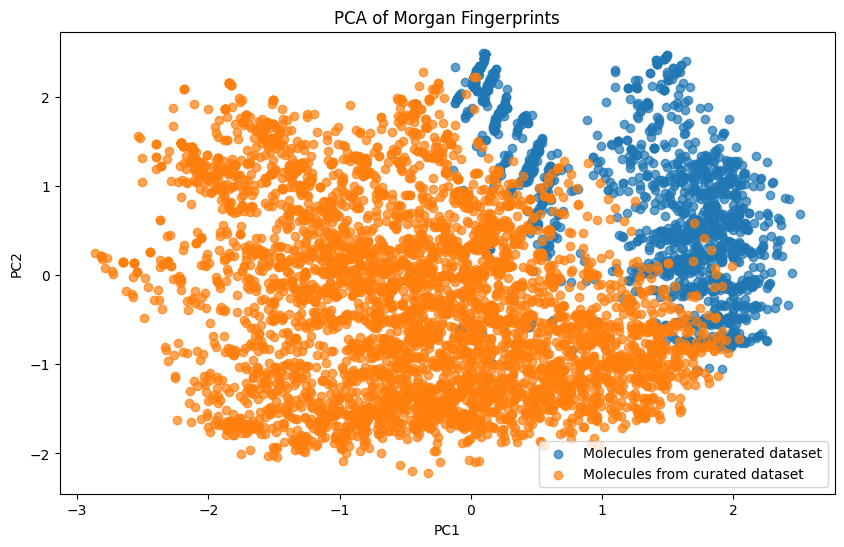

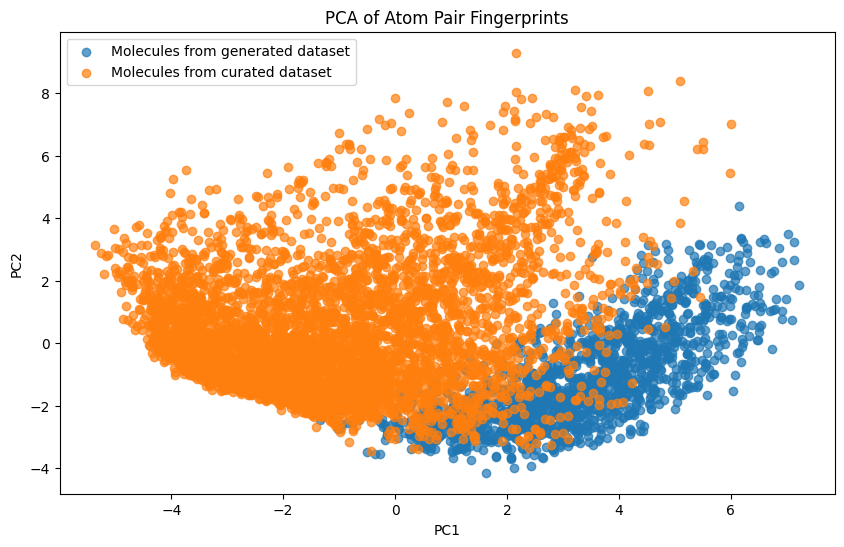

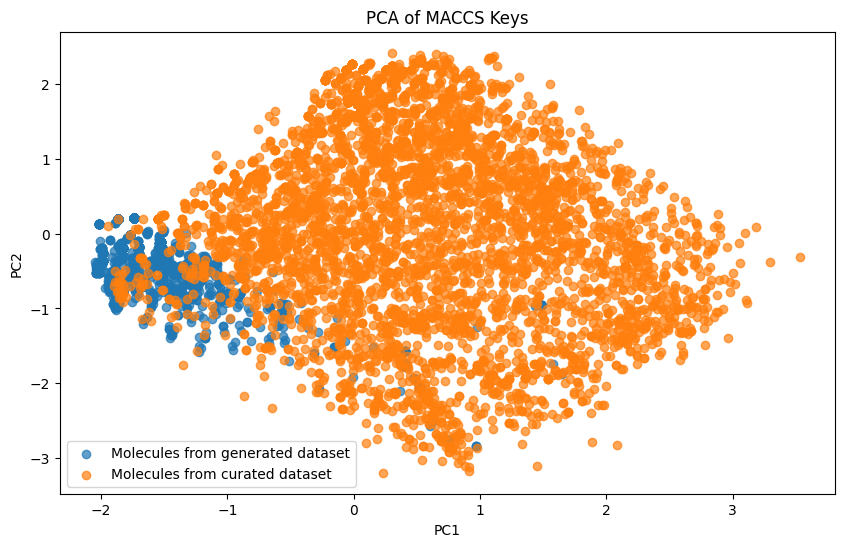

In [4]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
# Function to generate Morgan fingerprints
def generate_embeddings(smiles_list):
    embeddings = []
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
            embeddings.append(np.array(fp))
        else:
            embeddings.append(np.zeros(2048))  
    return np.array(embeddings)

# Function to generate Atom Pair fingerprints
def generate_atom_pair_fingerprints(smiles_list):
    atom_pair_fps = []
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
            
            fp = AllChem.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=2048)
            atom_pair_fps.append(np.array(fp))
        else:
            atom_pair_fps.append(np.zeros(2048))  
    return np.array(atom_pair_fps)

# Function to generate MACCS keys 
def generate_maccs_keys(smiles_list):
    maccs_keys = []
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
            keys = MACCSkeys.GenMACCSKeys(mol)
            maccs_keys.append(np.array(keys))
        else:
            maccs_keys.append(np.zeros(166))
    return np.array(maccs_keys)


df1 = pd.read_csv('../../data/ARGVA/filtered_generated_smiles.csv')
df2 = pd.read_csv('../../data/curated dataset/curated_GS_LF_merged_cleaned.csv')


morgan_fps1 = generate_embeddings(df1['SMILE'].tolist())
morgan_fps2 = generate_embeddings(df2['nonStereoSMILES'].tolist())


atom_pair_fps1 = generate_atom_pair_fingerprints(df1['SMILE'].tolist())
atom_pair_fps2 = generate_atom_pair_fingerprints(df2['nonStereoSMILES'].tolist())


maccs_keys1 = generate_maccs_keys(df1['SMILE'].tolist())
maccs_keys2 = generate_maccs_keys(df2['nonStereoSMILES'].tolist())


morgan_fps_combined = np.vstack([morgan_fps1, morgan_fps2])
atom_pair_fps_combined = np.vstack([atom_pair_fps1, atom_pair_fps2])
maccs_keys_combined = np.vstack([maccs_keys1, maccs_keys2])


pca_morgan = PCA(n_components=2)
pca_morgan_result = pca_morgan.fit_transform(morgan_fps_combined)

pca_atom_pair = PCA(n_components=2)
pca_atom_pair_result = pca_atom_pair.fit_transform(atom_pair_fps_combined)

pca_maccs = PCA(n_components=2)
pca_maccs_result = pca_maccs.fit_transform(maccs_keys_combined)

# Plot the PCA results for Morgan fingerprints
plt.figure(figsize=(10, 6))
plt.scatter(pca_morgan_result[:len(morgan_fps1), 0], pca_morgan_result[:len(morgan_fps1), 1], label='Molecules from generated dataset', alpha=0.7)
plt.scatter(pca_morgan_result[len(morgan_fps1):, 0], pca_morgan_result[len(morgan_fps1):, 1], label='Molecules from curated dataset', alpha=0.7)
plt.title('PCA of Morgan Fingerprints')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
output_folder = '../../figures/ARGVA/Fingerprints/Morgan_Fingerprints/'  
os.makedirs(output_folder, exist_ok=True)  
dpi_values = [300, 600, 1200]  
for dpi in dpi_values:
    plt.savefig(f"{output_folder}Morgan_Fingerprints_{dpi}dpi.png", dpi=dpi, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(pca_atom_pair_result[:len(atom_pair_fps1), 0], pca_atom_pair_result[:len(atom_pair_fps1), 1], label='Molecules from generated dataset', alpha=0.7)
plt.scatter(pca_atom_pair_result[len(atom_pair_fps1):, 0], pca_atom_pair_result[len(atom_pair_fps1):, 1], label='Molecules from curated dataset', alpha=0.7)
plt.title('PCA of Atom Pair Fingerprints')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
output_folder = '../../figures/ARGVA/Fingerprints/AtomPair_Fingerprints/'  
os.makedirs(output_folder, exist_ok=True)  
dpi_values = [300, 600, 1200]  
for dpi in dpi_values:
    plt.savefig(f"{output_folder}AtomPair_Fingerprints_{dpi}dpi.png", dpi=dpi, bbox_inches='tight')
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(pca_maccs_result[:len(maccs_keys1), 0], pca_maccs_result[:len(maccs_keys1), 1], label='Molecules from generated dataset', alpha=0.7)
plt.scatter(pca_maccs_result[len(maccs_keys1):, 0], pca_maccs_result[len(maccs_keys1):, 1], label='Molecules from curated dataset', alpha=0.7)
plt.title('PCA of MACCS Keys')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
output_folder = '../../figures/ARGVA/Fingerprints/MACCS_Fingerprints/'
os.makedirs(output_folder, exist_ok=True)  
dpi_values = [300, 600, 1200]
for dpi in dpi_values:
    plt.savefig(f"{output_folder}MACCS_Fingerprints_{dpi}dpi.png", dpi=dpi, bbox_inches='tight')
plt.show()


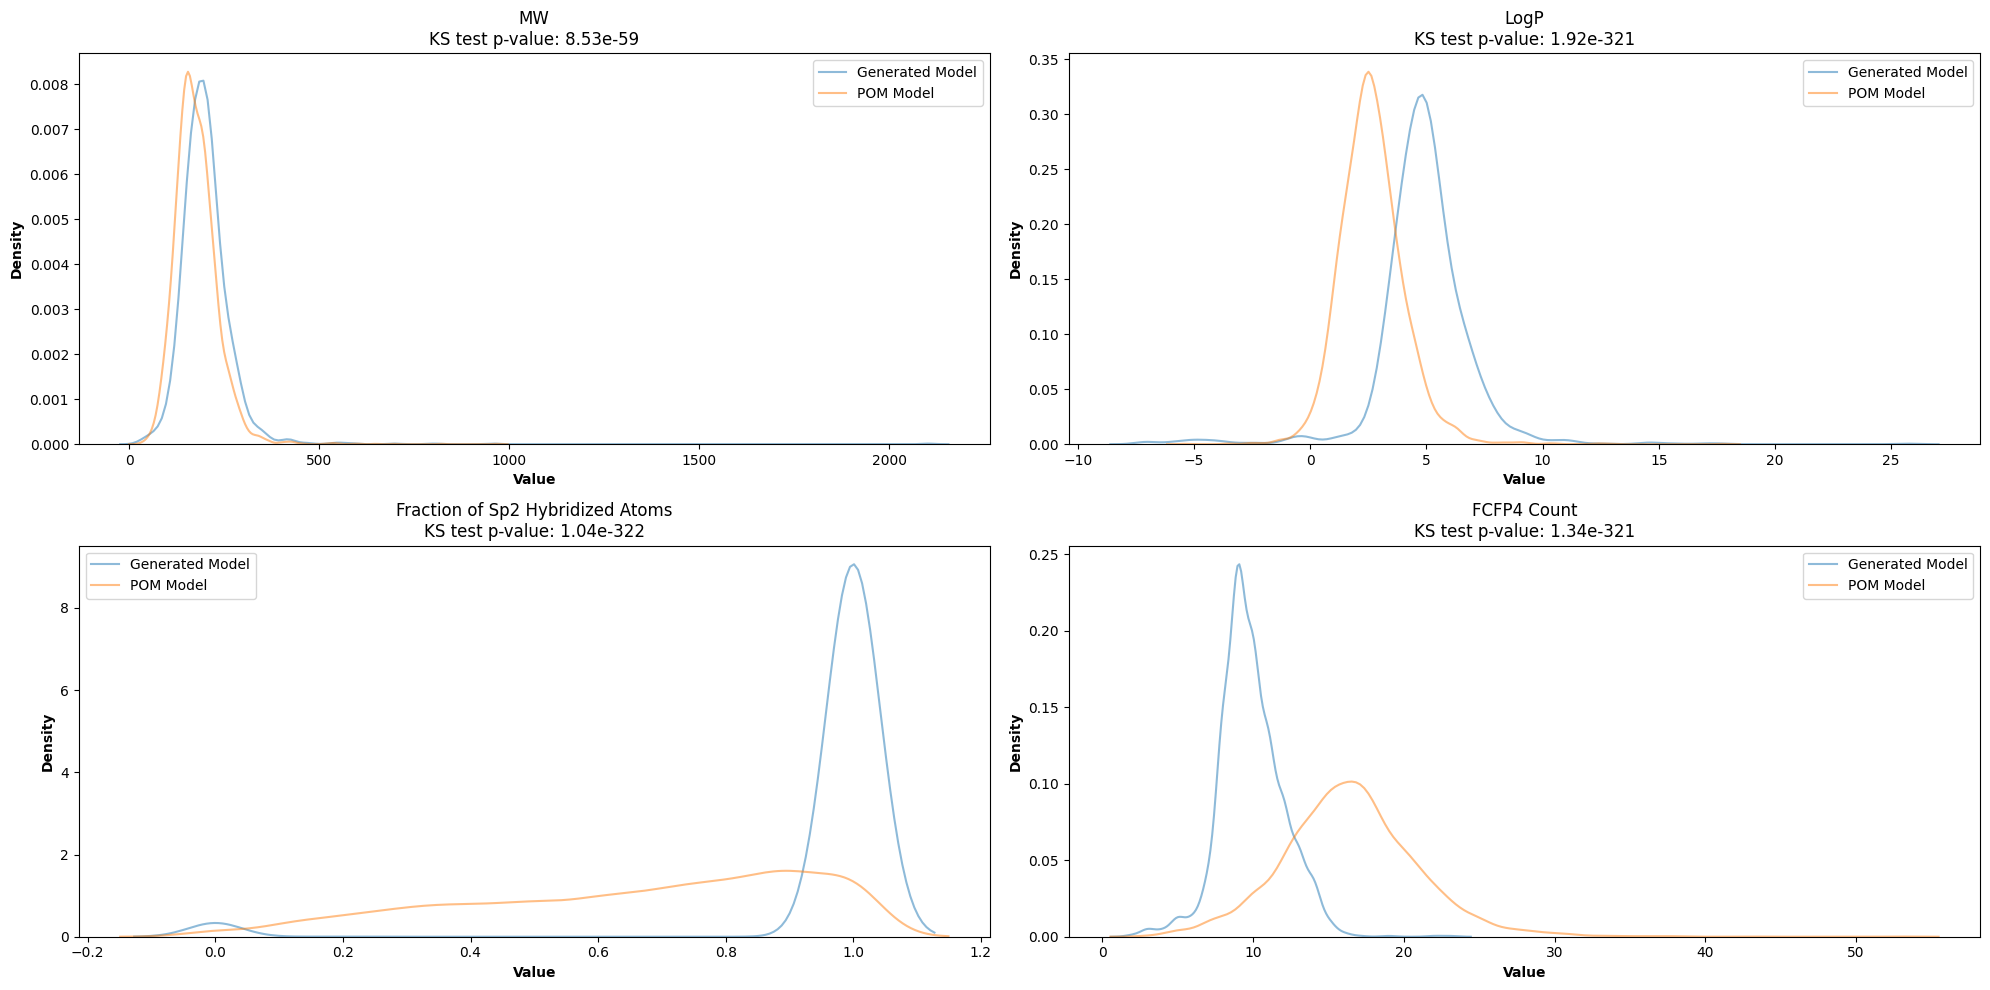

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen
from scipy import stats
import seaborn as sns
from rdkit.Chem import rdMolDescriptors

def calculate_molecular_properties(smiles_list):
    """Calculate various molecular properties for a list of SMILES strings."""
    properties = {
        'MW': [],  # Molecular Weight
        'LogP': [],  # Lipophilicity
        # 'SlogP_VSA3':[], # SlogP VSA3
        'Fraction of Sp2 Hybridized Atoms':[], # Fraction of Sp2 Hybridized Atoms
        'FCFP4 Count':[], # FCFP4 Count,
    }
    
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
            properties['MW'].append(Descriptors.ExactMolWt(mol))
            properties['LogP'].append(Crippen.MolLogP(mol))
            properties['Fraction of Sp2 Hybridized Atoms'].append(rdMolDescriptors.CalcFractionCSP3(mol))
            properties['FCFP4 Count'].append(len(AllChem.GetMorganFingerprintAsBitVect(mol, 2, useFeatures=True).GetOnBits()))
            
        else:
            for key in properties:
                properties[key].append(np.nan)
    
    return pd.DataFrame(properties)

def plot_property_distributions(props1, props2, dataset1_name="Generated Model", dataset2_name="POM Model"):
    """Plot distribution comparisons of molecular properties."""
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    axes = axes.ravel()
    
    properties = list(props1.columns)
    for i, prop in enumerate(properties):
        # Kernel Density Estimation plot
        sns.kdeplot(data=props1[prop], ax=axes[i], label=dataset1_name, alpha=0.5)
        sns.kdeplot(data=props2[prop], ax=axes[i], label=dataset2_name, alpha=0.5)
        
        # Performing Kolmogorov-Smirnov test
        ks_stat, p_value = stats.ks_2samp(props1[prop].dropna(), props2[prop].dropna())

        axes[i].set_title(f'{prop}\nKS test p-value: {p_value:.2e}')
        axes[i].set_xlabel('Value', fontweight='bold')
        axes[i].set_ylabel('Density', fontweight='bold')
        axes[i].legend(fontsize=12)
        
        axes[i].legend()

    plt.tight_layout()
    output_folder = '../../figures/ARGVA/KS_test/'  
    os.makedirs(output_folder, exist_ok=True)  
    dpi_values = [300, 600, 1200]  
    for dpi in dpi_values:
        plt.savefig(f"{output_folder}KS_test_{dpi}dpi.png", dpi=dpi, bbox_inches='tight')
    
    return fig

def compare_datasets(df1, df2, smiles_col1='SMILE', smiles_col2='nonStereoSMILES'):
    """Comprehensive comparison of two molecular datasets."""
    
    
    props1 = calculate_molecular_properties(df1[smiles_col1])
    props2 = calculate_molecular_properties(df2[smiles_col2])
    
    
    prop_fig = plot_property_distributions(props1, props2)
    
    
    summary = {
        'Generated_Model': props1.describe(),
        'POM_Model': props2.describe()
    }
    
    return summary, prop_fig


summary, figures = compare_datasets(df1, df2)
plt.show()


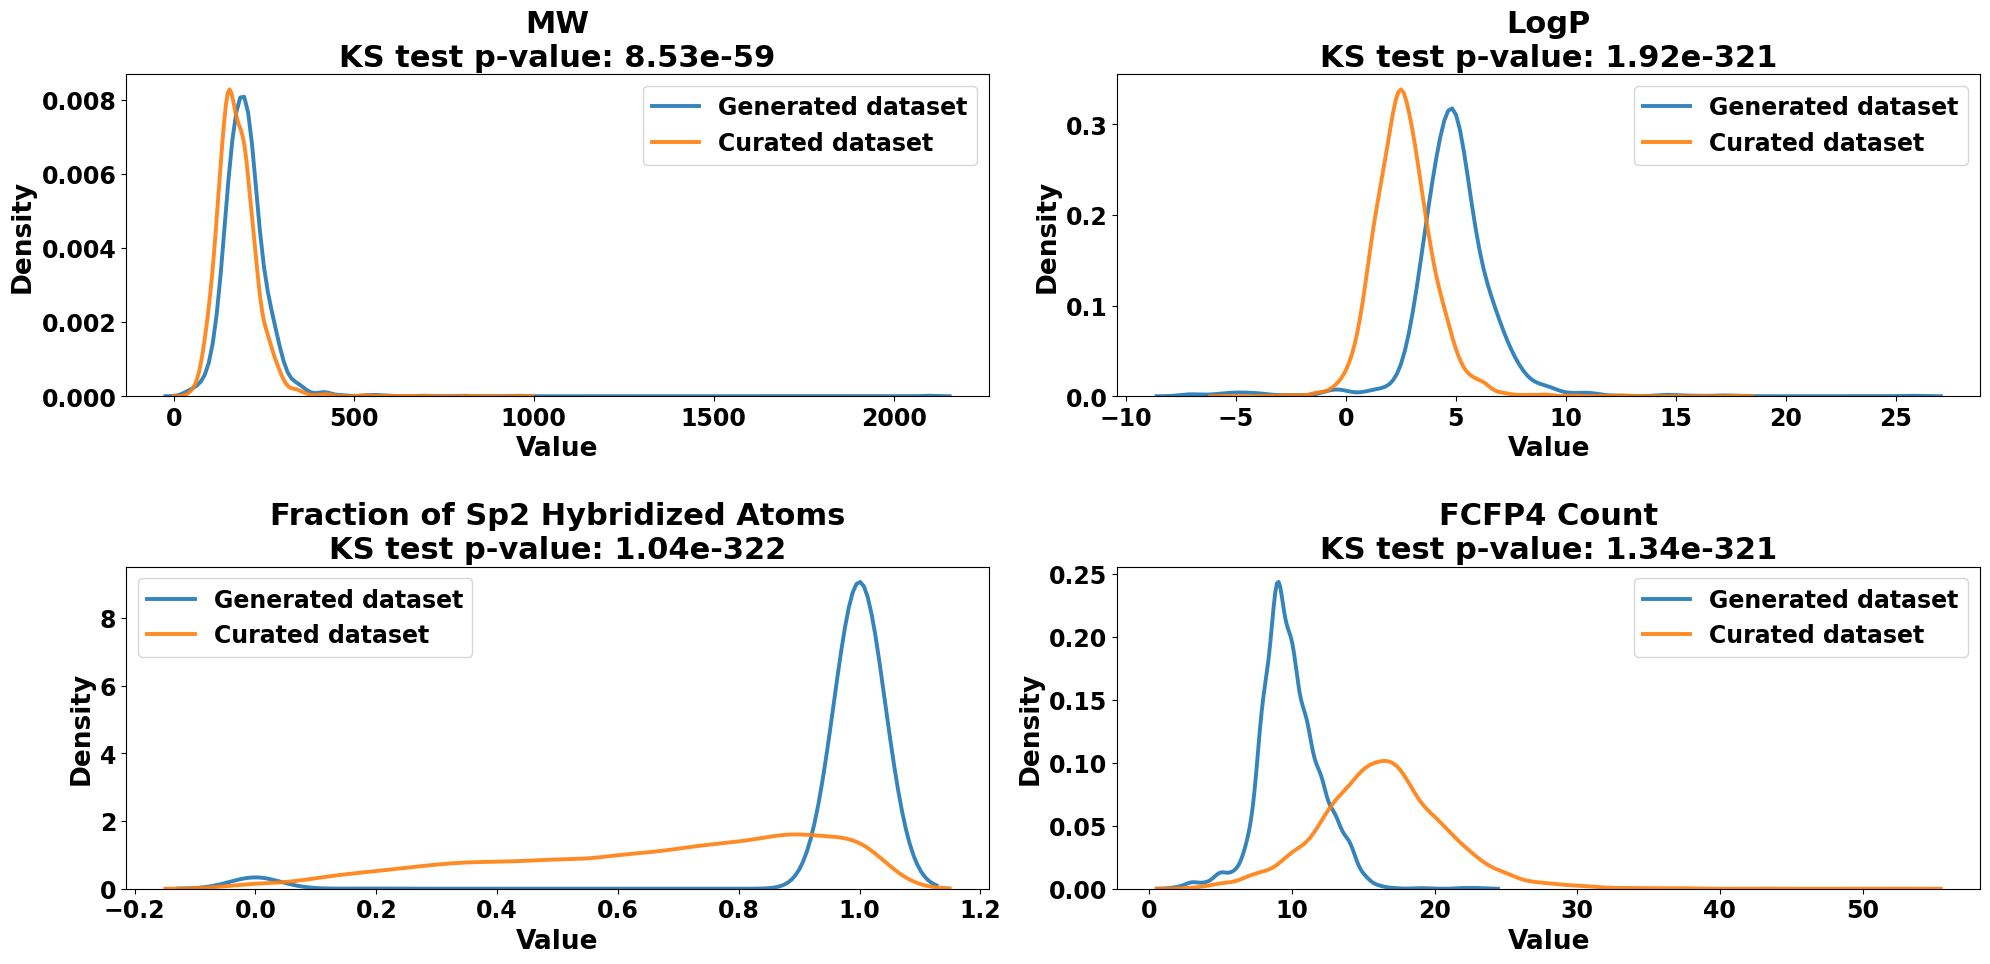

In [6]:
def plot_property_distributions(props1, props2, dataset1_name="Generated dataset", dataset2_name="Curated dataset"):
    """Plot distribution comparisons of molecular properties."""
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    axes = axes.ravel()
    
    properties = list(props1.columns)
    for i, prop in enumerate(properties):
        
        sns.kdeplot(data=props1[prop], ax=axes[i], label=dataset1_name, alpha=0.9, linewidth=2.8)
        sns.kdeplot(data=props2[prop], ax=axes[i], label=dataset2_name, alpha=0.9, linewidth=2.8)
        
        
        ks_stat, p_value = stats.ks_2samp(props1[prop].dropna(), props2[prop].dropna())
        
        
        axes[i].set_title(f'{prop}\nKS test p-value: {p_value:.2e}', fontweight='bold', fontsize=22)
        
        
        axes[i].set_xlabel('Value', fontweight='bold', fontsize=19)
        axes[i].set_ylabel('Density', fontweight='bold', fontsize=19)
        
        
        axes[i].tick_params(axis='both', which='major', labelsize=17)
        for label in axes[i].get_xticklabels() + axes[i].get_yticklabels():
            label.set_fontweight('bold')
        
        
        
        legend = axes[i].legend(fontsize=17, loc='best')
        for text in legend.get_texts():
            text.set_fontweight('bold')
    plt.subplots_adjust(hspace=10000)
    
    plt.tight_layout()
    
    
    # Save the figure in multiple DPI values
    output_folder = '../../figures/ARGVA/KS_test/'  
    os.makedirs(output_folder, exist_ok=True)  
    dpi_values = [300, 600, 1200]  
    for dpi in dpi_values:
        plt.savefig(f"{output_folder}KS_test_{dpi}dpi.png", dpi=dpi, bbox_inches='tight')
    
    return fig

summary, figures = compare_datasets(df1, df2)
plt.show()


Statistical Test Results:
                                  KS_statistic      KS_pvalue  MW_statistic  \
MW                                    0.233936   8.531487e-59     4928069.5   
LogP                                  0.669568  1.916975e-321     6848414.0   
TPSA                                  0.903280   0.000000e+00      461420.5   
SlogP_VSA3                            0.742892  1.101766e-321     1023081.0   
Fraction of Sp2 Hybridized Atoms      0.831222  1.037538e-322     6975747.5   
FCFP4 Count                           0.721060  1.343859e-321      656178.5   

                                     MW_pvalue  T_statistic       T_pvalue  \
MW                                1.577679e-60    11.728074   7.124795e-31   
LogP                              0.000000e+00    40.486533  3.675252e-267   
TPSA                              0.000000e+00   -37.890764  1.344654e-243   
SlogP_VSA3                        0.000000e+00   -39.332357  2.446456e-268   
Fraction of Sp2 Hybridized At

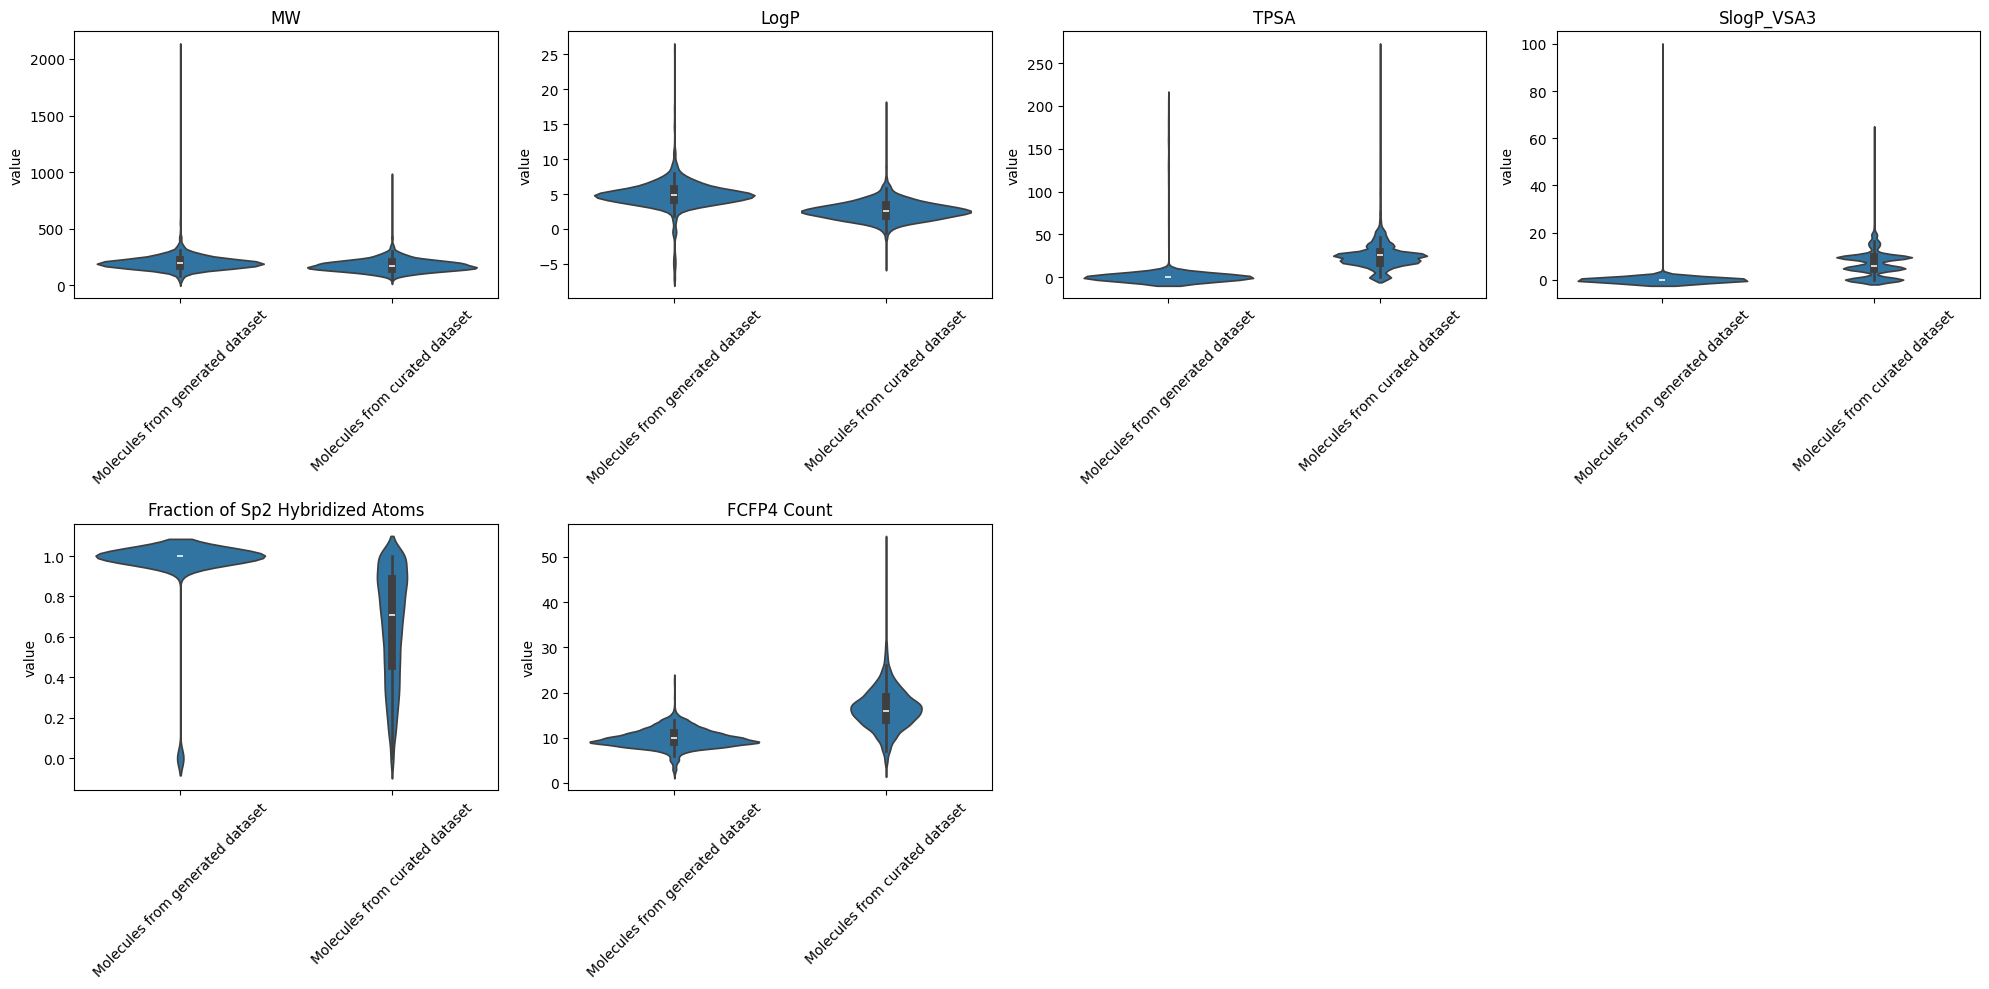

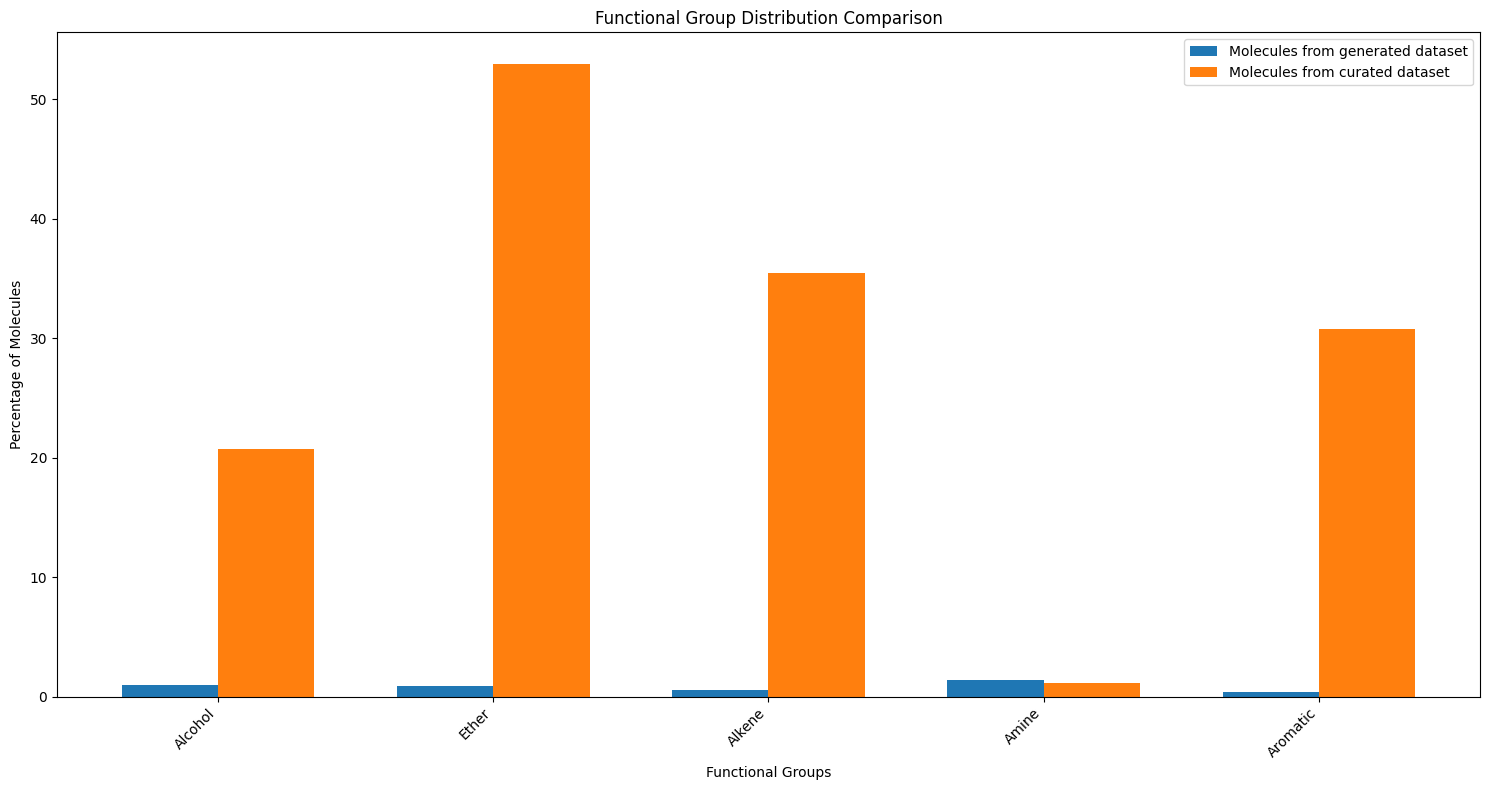

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, AllChem, rdMolDescriptors

from rdkit.Chem import Crippen
from scipy import stats
import seaborn as sns
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import jensenshannon
from scipy.stats import mannwhitneyu, ttest_ind
import warnings
warnings.filterwarnings('ignore')


def calculate_extended_properties(smiles_list):
    """Calculate an extended set of molecular properties for SMILES strings."""
    properties = {
        # Basic properties
        'MW': [],  # Molecular Weight
        'LogP': [],  # Lipophilicity
        'TPSA': [],  # Topological Polar Surface Area

        'SlogP_VSA3':[], # SlogP VSA3
        'Fraction of Sp2 Hybridized Atoms':[], # Fraction of Sp2 Hybridized Atoms
        'FCFP4 Count':[], # FCFP4 Count,
    }
    
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
            # Basic properties
            properties['MW'].append(Descriptors.ExactMolWt(mol))
            properties['LogP'].append(Crippen.MolLogP(mol))
            properties['TPSA'].append(Descriptors.TPSA(mol))


            properties['SlogP_VSA3'].append(Descriptors.SlogP_VSA3(mol))
            properties['Fraction of Sp2 Hybridized Atoms'].append(rdMolDescriptors.CalcFractionCSP3(mol))
            properties['FCFP4 Count'].append(len(AllChem.GetMorganFingerprintAsBitVect(mol, 2, useFeatures=True).GetOnBits()))
        else:
            for key in properties:
                properties[key].append(np.nan)
    
    return pd.DataFrame(properties)

def analyze_extended_functional_groups(smiles_list):
    """Analyze an extended set of functional groups in molecules."""
    functional_groups = {
        'Alcohol': '[OH]',
        'Amine': '[NH2]',
        'Carboxylic Acid': '[CX3](=O)[OH]',
        'Ester': '[CX3](=O)[OX2H0]',
        'Ether': '[OX2H0]',
        'Ketone': '[CX3](=O)[CX4]',
        'Aldehyde': '[CX3H1](=O)',
        'Aromatic': 'a',
        'Alkene': '[C]=[C]',
        'Alkyne': '[C]#[C]',
        'Amide': '[NX3][CX3](=[OX1])',
        'Nitro': '[N+](=O)[O-]',
        'Nitrile': '[C]#[N]',
        'Sulfonic Acid': '[SX4](=[OX1])(=[OX1])[OX2H]',
        #'Sulfonamide': '[SX4](=[OX1])(=[OX1])[NX3]',
        'Phosphate': '[P]([O])[O]',
        'Halogen': '[F,Cl,Br,I]'
    }
    
    counts = defaultdict(int)
    total_mols = len(smiles_list)
    
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
            for name, smarts in functional_groups.items():
                pattern = Chem.MolFromSmarts(smarts)
                if mol.HasSubstructMatch(pattern):
                    counts[name] += 1
    
    percentages = {k: (v/total_mols)*100 for k, v in counts.items()}
    return percentages

def calculate_statistical_tests(props1, props2):
    """Perform multiple statistical tests between two datasets."""
    results = {}
    for column in props1.columns:
        data1 = props1[column].dropna()
        data2 = props2[column].dropna()
        
        # Kolmogorov-Smirnov test
        ks_stat, ks_pval = stats.ks_2samp(data1, data2)
        
        # Mann-Whitney U test
        mw_stat, mw_pval = mannwhitneyu(data1, data2, alternative='two-sided')
        
        # T-test
        t_stat, t_pval = ttest_ind(data1, data2, equal_var=False)
        
        # Jensen-Shannon divergence
        # Normalize data for JSD calculation
        min_val = min(data1.min(), data2.min())
        max_val = max(data1.max(), data2.max())
        hist1, bins = np.histogram(data1, bins=50, range=(min_val, max_val), density=True)
        hist2, _ = np.histogram(data2, bins=50, range=(min_val, max_val), density=True)
        hist1 = hist1 + 1e-10  # Avoid zero values
        hist2 = hist2 + 1e-10
        hist1 = hist1 / hist1.sum()
        hist2 = hist2 / hist2.sum()
        jsd = jensenshannon(hist1, hist2)
        
        results[column] = {
            'KS_statistic': ks_stat,
            'KS_pvalue': ks_pval,
            'MW_statistic': mw_stat,
            'MW_pvalue': mw_pval,
            'T_statistic': t_stat,
            'T_pvalue': t_pval,
            'Jensen_Shannon_divergence': jsd
        }
    
    return pd.DataFrame(results).T

def plot_extended_analysis(props1, props2, dataset1_name="Molecules from generated dataset", dataset2_name="Molecules from curated dataset"):
    """Create enhanced visualization of property distributions."""
    n_properties = len(props1.columns)
    n_cols = 4
    n_rows = (n_properties + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.ravel()
    
    for i, prop in enumerate(props1.columns):
        # Violin plot with boxplot inside
        data = pd.DataFrame({
            dataset1_name: props1[prop].dropna(),
            dataset2_name: props2[prop].dropna()
        }).melt()
        
        sns.violinplot(data=data, x='variable', y='value', ax=axes[i], inner='box')
        axes[i].set_title(f'{prop}')
        axes[i].set_xlabel('')
        axes[i].tick_params(axis='x', rotation=45)
    
    
    for i in range(n_properties, len(axes)):
        fig.delaxes(axes[i])
    output_folder = '../../figures/ARGVA/Violoin Plots/'
    os.makedirs(output_folder, exist_ok=True)  
    dpi_values = [300, 600]  # DPI levels
    for dpi in dpi_values:
        plt.savefig(f"{output_folder}Violoin_Plots_{dpi}dpi.png", dpi=dpi, bbox_inches='tight')

    plt.tight_layout()
    return fig

def compare_extended_datasets(df1, df2, smiles_col1='SMILE', smiles_col2='nonStereoSMILES'):
    """Perform comprehensive comparison of two molecular datasets."""
    
    # Calculate extended molecular properties
    props1 = calculate_extended_properties(df1[smiles_col1])
    props2 = calculate_extended_properties(df2[smiles_col2])
    
    # Analyze extended functional groups
    fg1 = analyze_extended_functional_groups(df1[smiles_col1])
    fg2 = analyze_extended_functional_groups(df2[smiles_col2])
    
    # Statistical tests
    stats_results = calculate_statistical_tests(props1, props2)
    
    # Create visualizations
    prop_fig = plot_extended_analysis(props1, props2)
    
    # Functional group comparison plot
    plt.figure(figsize=(15, 8))
    groups = list(fg1.keys())
    x = np.arange(len(groups))
    width = 0.35
    
    plt.bar(x - width/2, [fg1[g] for g in groups], width, label='Molecules from generated dataset')
    plt.bar(x + width/2, [fg2[g] for g in groups], width, label='Molecules from curated dataset')
    
    plt.xlabel('Functional Groups')
    plt.ylabel('Percentage of Molecules')
    plt.title('Functional Group Distribution Comparison')
    plt.xticks(x, groups, rotation=45, ha='right')
    plt.legend()
    output_folder = '../../figures/ARGVA/Group_analysis/'
    os.makedirs(output_folder, exist_ok=True)  
    dpi_values = [300, 600, 1200]
    for dpi in dpi_values:
        plt.savefig(f"{output_folder}Funct_Group_analysis_{dpi}dpi.png", dpi=dpi, bbox_inches='tight')
    plt.tight_layout()
    
    
    summary = {
        'Molecules from generated dataset': props1.describe(),
        'PMolecules from curated dataset': props2.describe()
    }
    
    return summary, stats_results, prop_fig


summary, statistical_tests, figures = compare_extended_datasets(df1, df2)


print("\nStatistical Test Results:")
print(statistical_tests)
directory = '../../data/ARGVA/KS_test'
file_path = os.path.join(directory, 'KS_properties.csv')


if not os.path.exists(directory):
    os.makedirs(directory)


statistical_tests.to_csv(file_path)
plt.show()

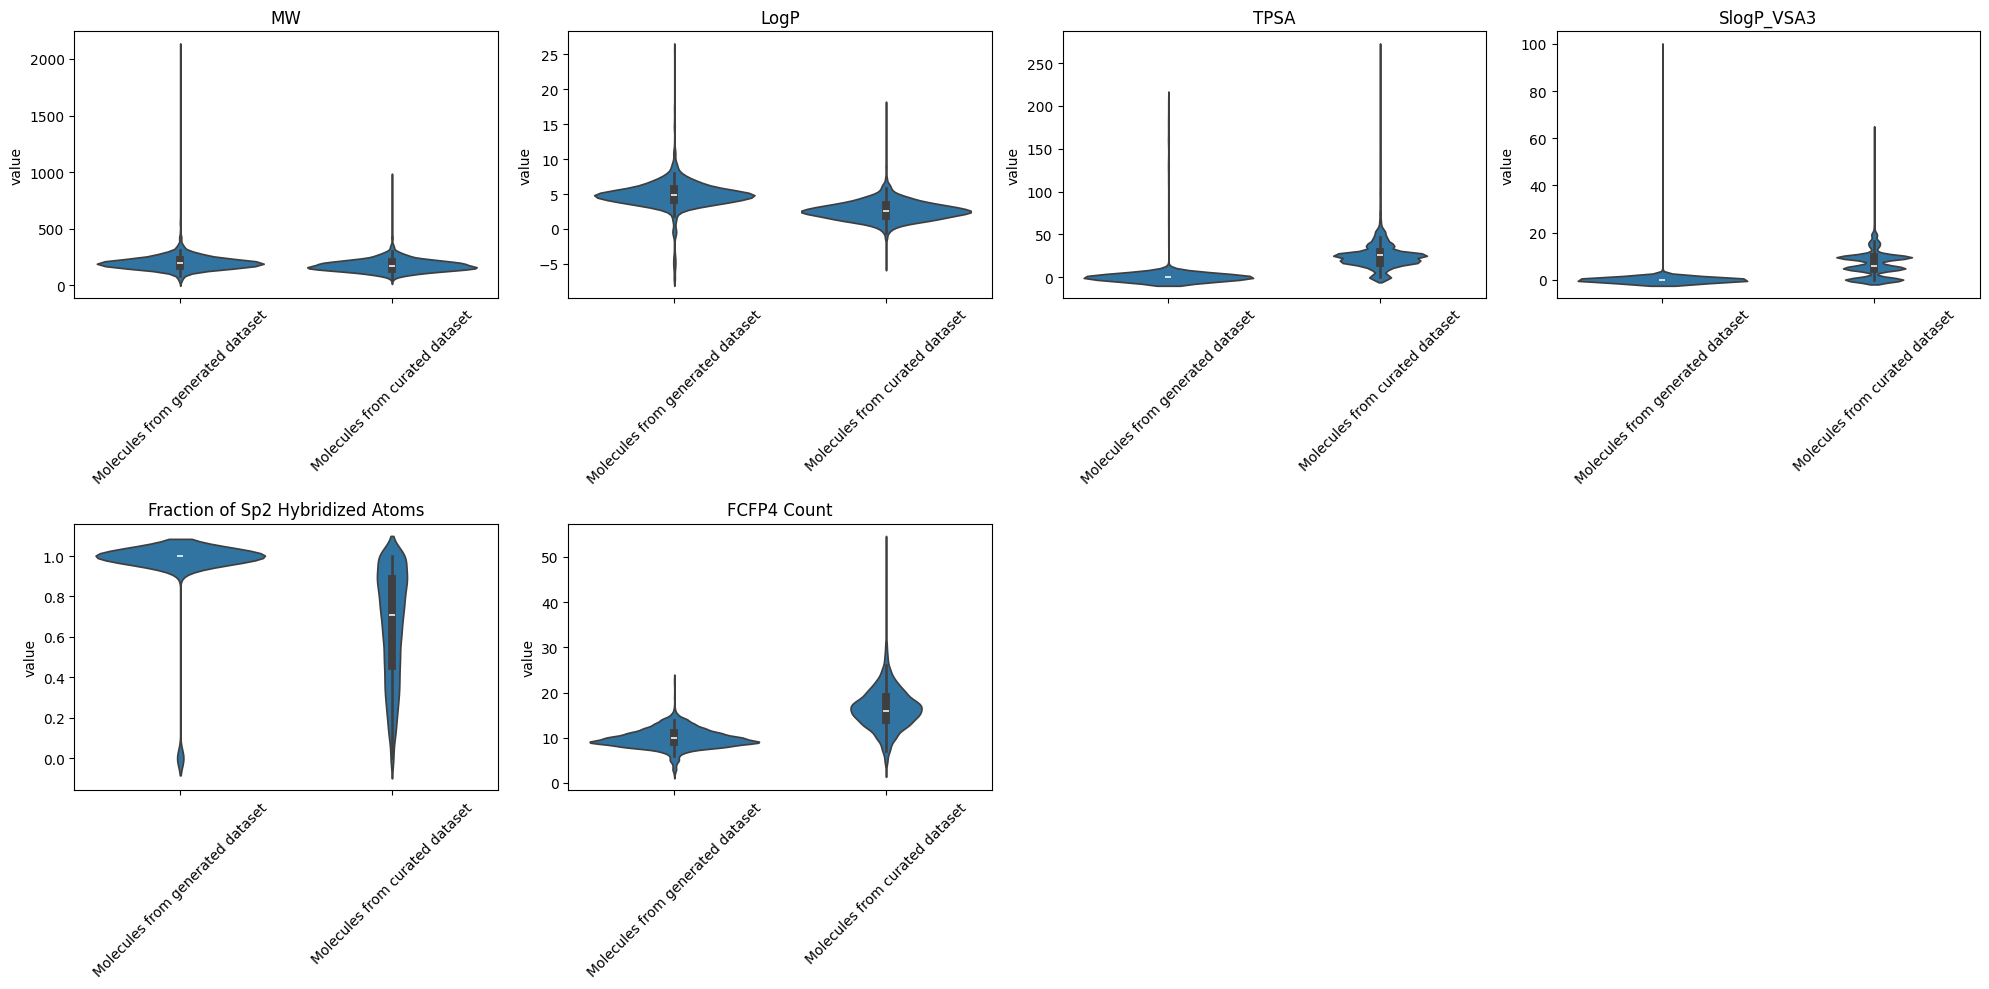

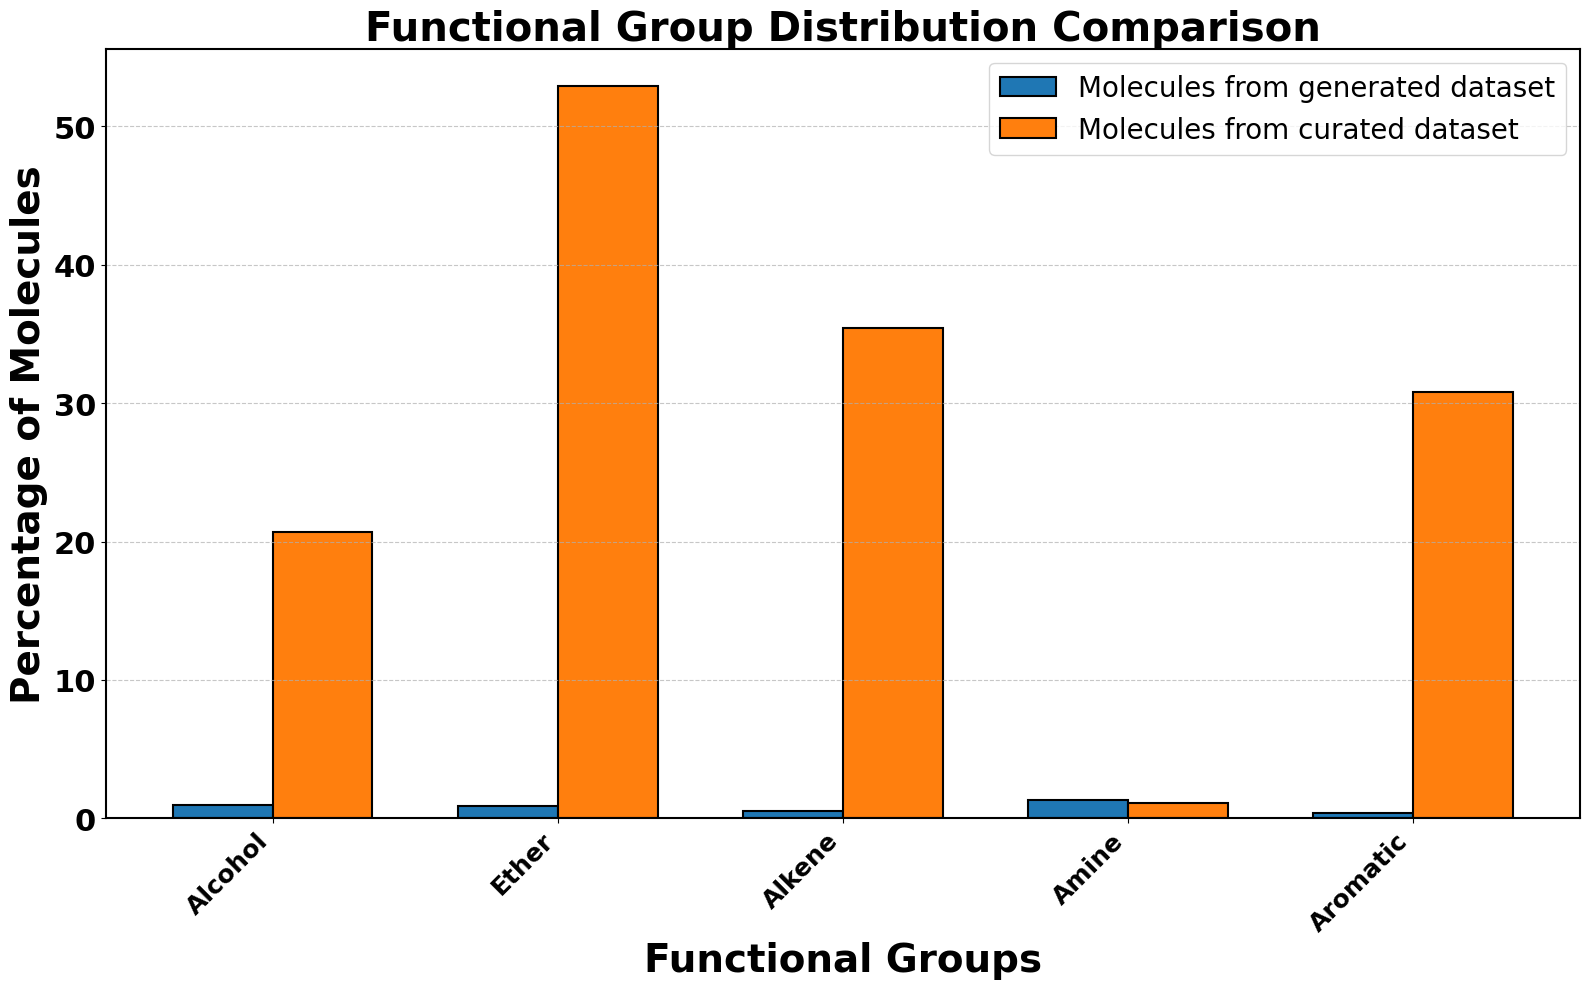


Statistical Test Results:
                                  KS_statistic      KS_pvalue  MW_statistic  \
MW                                    0.233936   8.531487e-59     4928069.5   
LogP                                  0.669568  1.916975e-321     6848414.0   
TPSA                                  0.903280   0.000000e+00      461420.5   
SlogP_VSA3                            0.742892  1.101766e-321     1023081.0   
Fraction of Sp2 Hybridized Atoms      0.831222  1.037538e-322     6975747.5   
FCFP4 Count                           0.721060  1.343859e-321      656178.5   

                                     MW_pvalue  T_statistic       T_pvalue  \
MW                                1.577679e-60    11.728074   7.124795e-31   
LogP                              0.000000e+00    40.486533  3.675252e-267   
TPSA                              0.000000e+00   -37.890764  1.344654e-243   
SlogP_VSA3                        0.000000e+00   -39.332357  2.446456e-268   
Fraction of Sp2 Hybridized At

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
from rdkit import RDLogger
import pandas as pd

df1 = pd.read_csv('../../data/ARGVA/filtered_generated_smiles.csv')
df2 = pd.read_csv('../../data/curated dataset/curated_GS_LF_merged_cleaned.csv')
# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')

def compare_extended_datasets(df1, df2, smiles_col1='SMILE', smiles_col2='nonStereoSMILES'):
    """Perform comprehensive comparison of two molecular datasets."""
    
    # Calculate extended molecular properties
    props1 = calculate_extended_properties(df1[smiles_col1])
    props2 = calculate_extended_properties(df2[smiles_col2])
    
    # Analyze extended functional groups
    fg1 = analyze_extended_functional_groups(df1[smiles_col1])
    fg2 = analyze_extended_functional_groups(df2[smiles_col2])
    
    # Statistical tests
    stats_results = calculate_statistical_tests(props1, props2)
    
    # Create visualizations
    prop_fig = plot_extended_analysis(props1, props2)
    
    # Functional group comparison plot
    plt.figure(figsize=(16, 10))
    groups = list(fg1.keys())
    x = np.arange(len(groups))
    width = 0.35
    
    bar1 = plt.bar(
        x - width / 2, 
        [fg1[g] for g in groups], 
        width, 
        label='Molecules from generated dataset', 
        edgecolor='black', 
        linewidth=1.5
    )
    bar2 = plt.bar(
        x + width / 2, 
        [fg2[g] for g in groups], 
        width, 
        label='Molecules from curated dataset', 
        edgecolor='black', 
        linewidth=1.5
    )
    
    plt.xlabel('Functional Groups', fontsize=28, fontweight='bold')
    plt.ylabel('Percentage of Molecules', fontsize=28, fontweight='bold')
    plt.title('Functional Group Distribution Comparison', fontsize=29, fontweight='bold')
    plt.xticks(x, groups, rotation=45, ha='right', fontsize=18, fontweight='bold')
    plt.yticks(fontsize=22, fontweight='bold')
    plt.legend(fontsize=20)
    
    # Bold grid and frame
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_linewidth(1.5)
    plt.gca().spines['right'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)

    # Save the figure
    output_folder = '../../figures/ARGVA/Group_analysis/'  # Specify the folder to save images
    os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist
    dpi_values = [300, 600, 1200]  # DPI levels
    for dpi in dpi_values:
        plt.savefig(f"{output_folder}Funct_Group_analysis_{dpi}dpi.png", dpi=dpi, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

    # Calculate summary statistics
    summary = {
        'Molecules from generated dataset': props1.describe(),
        'Molecules from curated dataset': props2.describe()
    }
    
    return summary, stats_results, prop_fig
# Run the extended analysis
summary, statistical_tests, figures = compare_extended_datasets(df1, df2)

# Display results
print("\nStatistical Test Results:")
print(statistical_tests)
directory = '../../data/ARGVA/KS_test'
file_path = os.path.join(directory, 'KS_properties.csv')

# Check if the directory exists, if not, create it
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the DataFrame to the CSV file
statistical_tests.to_csv(file_path)
plt.show()


In [9]:
from collections import defaultdict
from rdkit import Chem

def analyze_extended_functional_groups(smiles_list):
    """
    Analyze an extended set of functional groups in molecules including various
    alkyl groups, cyclic structures, and substituted variants.
    """
    functional_groups = {
        # Original groups
        'Alcohol': '[OH]',
        'Amine': '[NH2]',
        'Carboxylic Acid': '[CX3](=O)[OH]',
        'Ester': '[CX3](=O)[OX2H0]',
        'Ether': '[OX2H0]',
        'Ketone': '[CX3](=O)[CX4]',
        'Aldehyde': '[CX3H1](=O)',
        'Aromatic': 'a',
        'Alkene': '[C]=[C]',
        'Alkyne': '[C]#[C]',
        'Amide': '[NX3][CX3](=[OX1])',
        'Nitro': '[N+](=O)[O-]',
        'Nitrile': '[C]#[N]',
        'Sulfonic Acid': '[SX4](=[OX1])(=[OX1])[OX2H]',
        'Phosphate': '[P]([O])[O]',
        'Halogen': '[F,Cl,Br,I]',
        
        # New alkyl and related groups
        'Alkane': '[CX4]',  # Basic sp3 carbon
        'Methyl': '[CH3]',  # Methyl group
        'Ethyl': '[CH2][CH3]',  # Ethyl group
        'Propyl': '[CH2][CH2][CH3]',  # Propyl group
        'Butyl': '[CH2][CH2][CH2][CH3]',  # Butyl group
        'Isopropyl': '[CH]([CH3])[CH3]',  # Isopropyl group
        't-Butyl': '[C]([CH3])([CH3])[CH3]',  # tert-Butyl group
        
        # Cyclic structures
        'Cycloalkane_3': '[CR0]1[CR0][CR0]1',  # 3-membered ring
        'Cycloalkane_4': '[CR0]1[CR0][CR0][CR0]1',  # 4-membered ring
        'Cycloalkane_5': '[CR0]1[CR0][CR0][CR0][CR0]1',  # 5-membered ring
        'Cycloalkane_6': '[CR0]1[CR0][CR0][CR0][CR0][CR0]1',  # 6-membered ring
        
        # Branched structures
        'Branched_Carbon': '[CX4]([*])([*])[*]',  # Carbon with 3 non-H substituents
        'Highly_Branched': '[CX4]([CX4])([CX4])[CX4]',  # Carbon with multiple carbon substituents
        
        # Additional specific groups
        'Primary_Carbon': '[CH3][CX4]',  # Primary carbon (CH3-)
        'Secondary_Carbon': '[CH2]([CX4])[CX4]',  # Secondary carbon (-CH2-)
        'Tertiary_Carbon': '[CH]([CX4])([CX4])[CX4]',  # Tertiary carbon
        'Quaternary_Carbon': '[C]([CX4])([CX4])([CX4])[CX4]',  # Quaternary carbon
        
        # Heterocyclic structures
        'N_Heterocycle': '[#6]1~[#7]~[#6]~[#6]1',  # Basic N-containing ring
        'O_Heterocycle': '[#6]1~[#8]~[#6]~[#6]1',  # Basic O-containing ring
        
        # Extended conjugated systems
        #'Conjugated_Double_Bonds': '[C]=[C][C]=[C]',  # Conjugated double bonds
        'Extended_Aromatic': 'c1ccccc1c2ccccc2'  # Biphenyl-like structure
    }
    
    counts = defaultdict(int)
    total_mols = len(smiles_list)
    
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
            for name, smarts in functional_groups.items():
                try:
                    pattern = Chem.MolFromSmarts(smarts)
                    if pattern is not None and mol.HasSubstructMatch(pattern):
                        counts[name] += 1
                except:
                    continue  # Skip if SMARTS pattern is invalid
    
    percentages = {k: (v/total_mols)*100 for k, v in counts.items()}
    return percentages

def analyze_chain_length(smiles):
    """
    Helper function to analyze the longest carbon chain in a molecule.
    Returns the length of the longest continuous carbon chain.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0
    
    # Find all carbon atoms
    carbon_atoms = [i for i in range(mol.GetNumAtoms()) 
                   if mol.GetAtomWithIdx(i).GetSymbol() == 'C']
    
    max_chain = 0
    # For each carbon atom, try to find the longest chain starting from it
    for start in carbon_atoms:
        visited = set()
        stack = [(start, 1)]
        while stack:
            current, length = stack.pop()
            visited.add(current)
            max_chain = max(max_chain, length)
            
            # Get neighboring carbon atoms
            for neighbor in mol.GetAtomWithIdx(current).GetNeighbors():
                if neighbor.GetIdx() not in visited and neighbor.GetSymbol() == 'C':
                    stack.append((neighbor.GetIdx(), length + 1))
                    
    return max_chain

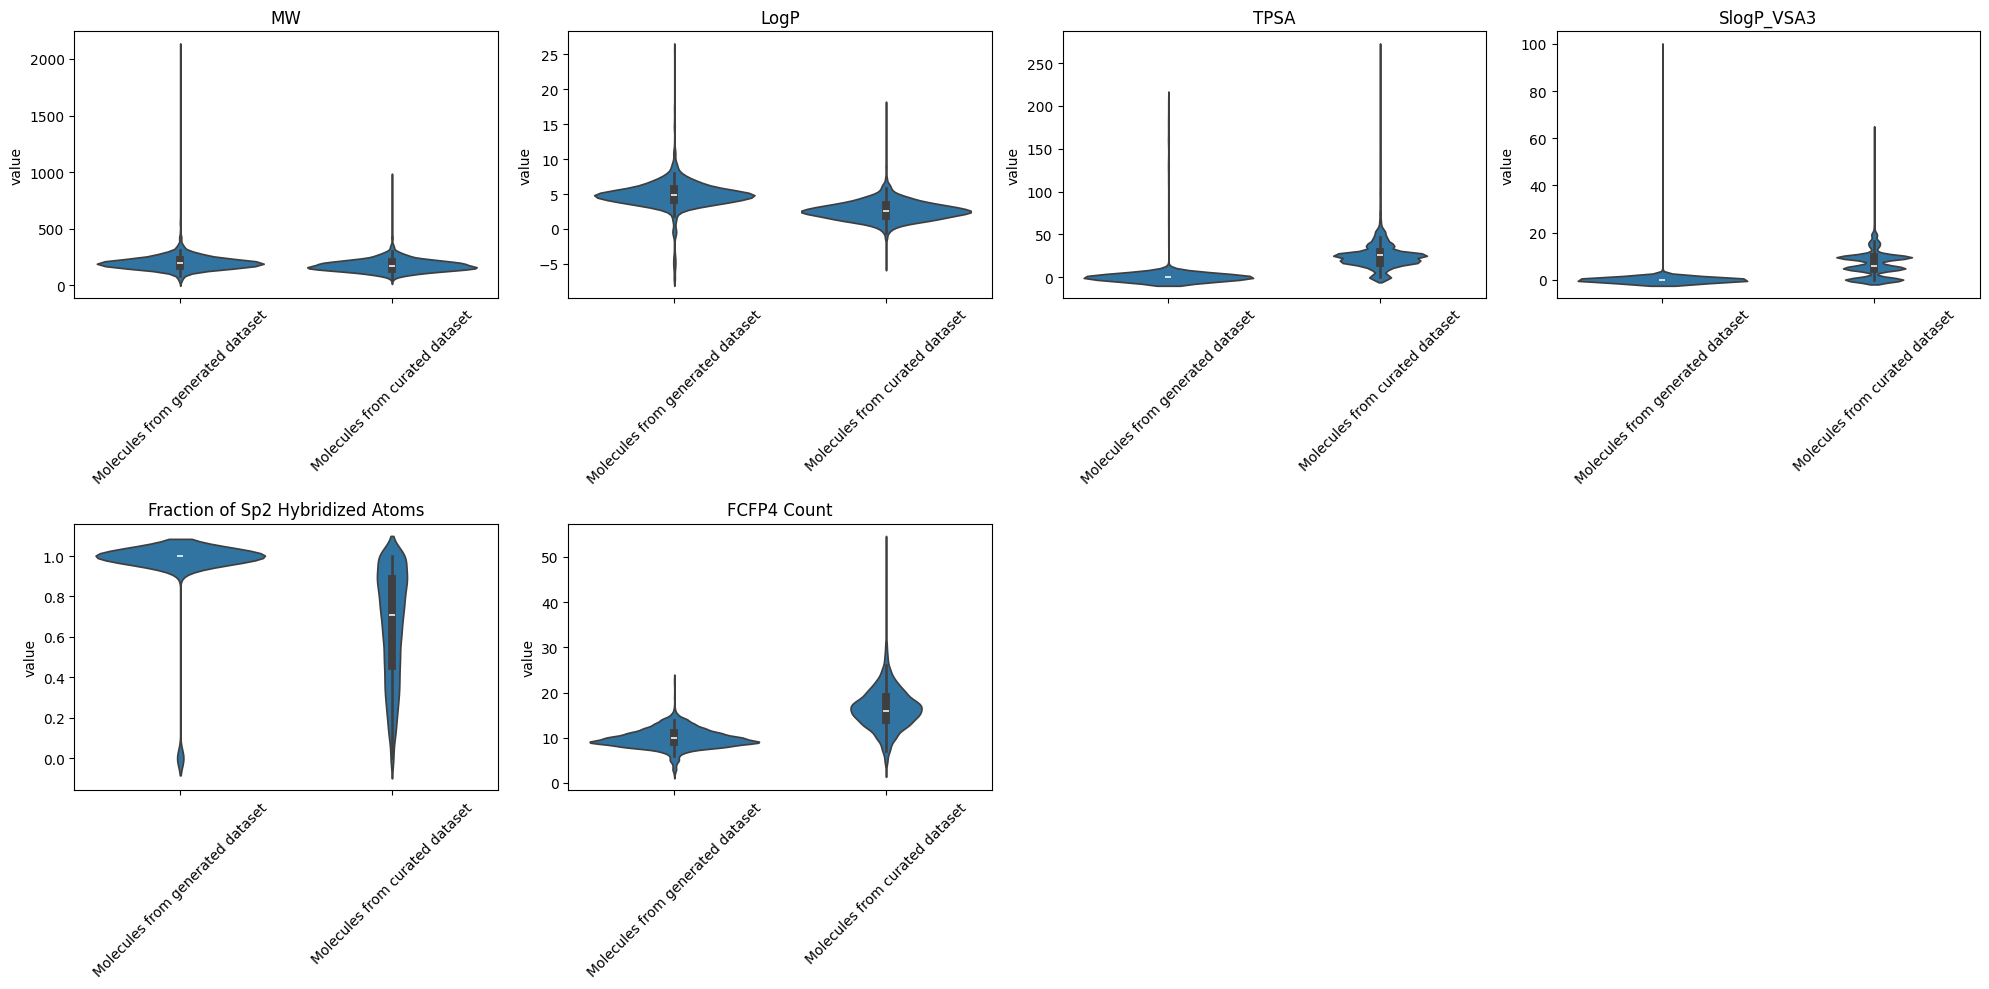

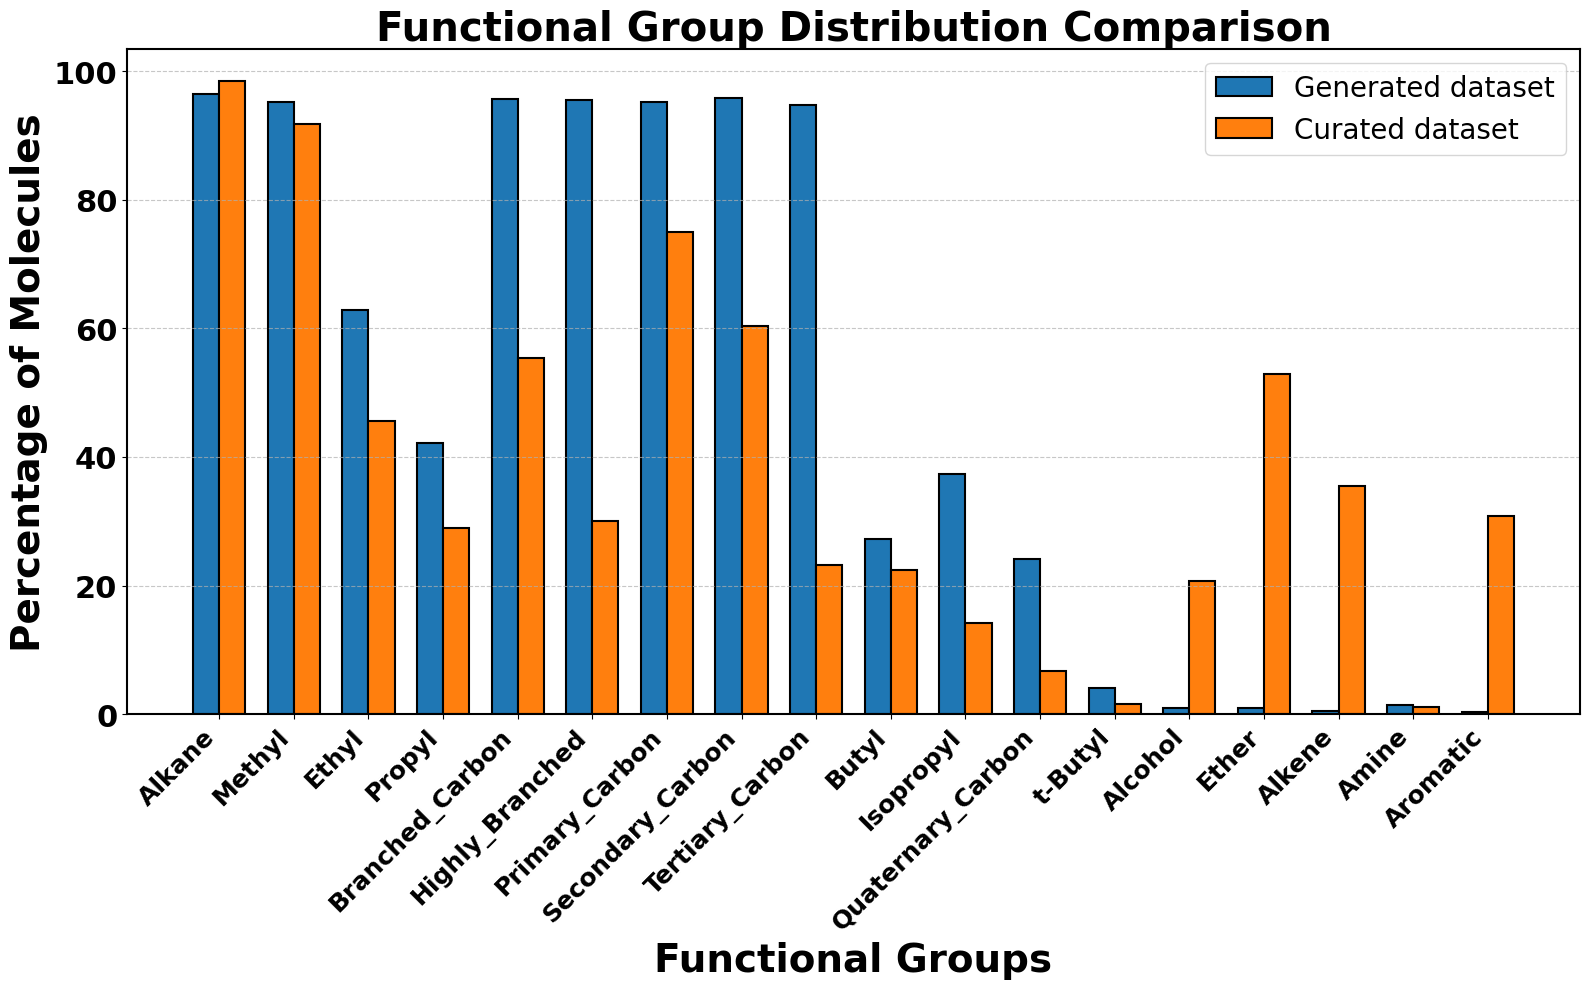


Statistical Test Results:
                                  KS_statistic      KS_pvalue  MW_statistic  \
MW                                    0.233936   8.531487e-59     4928069.5   
LogP                                  0.669568  1.916975e-321     6848414.0   
TPSA                                  0.903280   0.000000e+00      461420.5   
SlogP_VSA3                            0.742892  1.101766e-321     1023081.0   
Fraction of Sp2 Hybridized Atoms      0.831222  1.037538e-322     6975747.5   
FCFP4 Count                           0.721060  1.343859e-321      656178.5   

                                     MW_pvalue  T_statistic       T_pvalue  \
MW                                1.577679e-60    11.728074   7.124795e-31   
LogP                              0.000000e+00    40.486533  3.675252e-267   
TPSA                              0.000000e+00   -37.890764  1.344654e-243   
SlogP_VSA3                        0.000000e+00   -39.332357  2.446456e-268   
Fraction of Sp2 Hybridized At

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
from rdkit import RDLogger
import pandas as pd

# df1 = pd.read_csv('../../data/ARGVA/filtered_generated_smiles.csv')
# df2 = pd.read_csv('../../data/curated dataset/curated_GS_LF_merged_cleaned.csv')
# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')

def compare_extended_datasets(df1, df2, smiles_col1='SMILE', smiles_col2='nonStereoSMILES'):
    """Perform comprehensive comparison of two molecular datasets."""
    
    # Calculate extended molecular properties
    props1 = calculate_extended_properties(df1[smiles_col1])
    props2 = calculate_extended_properties(df2[smiles_col2])
    
    # Analyze extended functional groups
    fg1 = analyze_extended_functional_groups(df1[smiles_col1])
    fg2 = analyze_extended_functional_groups(df2[smiles_col2])
    
    # Statistical tests
    stats_results = calculate_statistical_tests(props1, props2)
    
    # Create visualizations
    prop_fig = plot_extended_analysis(props1, props2)
    
    # Functional group comparison plot
    plt.figure(figsize=(16, 10))
    groups = list(fg1.keys())
    x = np.arange(len(groups))
    width = 0.35
    
    bar1 = plt.bar(
        x - width / 2, 
        [fg1[g] for g in groups], 
        width, 
        label='Generated dataset', 
        edgecolor='black', 
        linewidth=1.5
    )
    bar2 = plt.bar(
        x + width / 2, 
        [fg2[g] for g in groups], 
        width, 
        label='Curated dataset', 
        edgecolor='black', 
        linewidth=1.5
    )
    
    plt.xlabel('Functional Groups', fontsize=28, fontweight='bold')
    plt.ylabel('Percentage of Molecules', fontsize=28, fontweight='bold')
    plt.title('Functional Group Distribution Comparison', fontsize=29, fontweight='bold')
    plt.xticks(x, groups, rotation=45, ha='right', fontsize=18, fontweight='bold')
    plt.yticks(fontsize=22, fontweight='bold')
    plt.legend(fontsize=20)
    
    # Bold grid and frame
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_linewidth(1.5)
    plt.gca().spines['right'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)

    # Save the figure
    output_folder = '../../figures/ARGVA/Group_analysis/'  # Specify the folder to save images
    os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist
    dpi_values = [300, 600, 1200]  # DPI levels
    for dpi in dpi_values:
        plt.savefig(f"{output_folder}Funct_Group_analysis_{dpi}dpi.png", dpi=dpi, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

    # Calculate summary statistics
    summary = {
        'Molecules from generated dataset': props1.describe(),
        'Molecules from curated dataset': props2.describe()
    }
    
    return summary, stats_results, prop_fig
# Run the extended analysis
summary, statistical_tests, figures = compare_extended_datasets(df1, df2)

# Display results
print("\nStatistical Test Results:")
print(statistical_tests)
directory = '../../data/ARGVA/KS_test'
file_path = os.path.join(directory, 'KS_properties.csv')

# Check if the directory exists, if not, create it
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the DataFrame to the CSV file
statistical_tests.to_csv(file_path)
plt.show()


In [11]:
from collections import defaultdict
from rdkit import Chem

def analyze_extended_functional_groups(smiles_list):
    """
    Analyze an extended set of functional groups in molecules including various
    alkyl groups, cyclic structures, and substituted variants.
    """
    functional_groups = {
        # Original groups
        'Alcohol': '[OH]',
        'Amine': '[NH2]',
        'Carboxylic Acid': '[CX3](=O)[OH]',
        'Ester': '[CX3](=O)[OX2H0]',
        'Ether': '[OX2H0]',
        'Ketone': '[CX3](=O)[CX4]',
        'Aldehyde': '[CX3H1](=O)',
        'Aromatic': 'a',
        'Alkene': '[C]=[C]',
        'Alkyne': '[C]#[C]',
        'Amide': '[NX3][CX3](=[OX1])',
        'Nitro': '[N+](=O)[O-]',
        'Nitrile': '[C]#[N]',
        'Sulfonic Acid': '[SX4](=[OX1])(=[OX1])[OX2H]',
        'Phosphate': '[P]([O])[O]',
        'Halogen': '[F,Cl,Br,I]',
        
        # New alkyl and related groups
        'Alkane': '[CX4]',  # Basic sp3 carbon
        'Methyl': '[CH3]',  # Methyl group
        'Ethyl': '[CH2][CH3]',  # Ethyl group
        'Propyl': '[CH2][CH2][CH3]',  # Propyl group
        'Butyl': '[CH2][CH2][CH2][CH3]',  # Butyl group
        'Isopropyl': '[CH]([CH3])[CH3]',  # Isopropyl group
        't-Butyl': '[C]([CH3])([CH3])[CH3]',  # tert-Butyl group
        
        # Cyclic structures
        'Cycloalkane_3': '[CR0]1[CR0][CR0]1',  # 3-membered ring
        'Cycloalkane_4': '[CR0]1[CR0][CR0][CR0]1',  # 4-membered ring
        'Cycloalkane_5': '[CR0]1[CR0][CR0][CR0][CR0]1',  # 5-membered ring
        'Cycloalkane_6': '[CR0]1[CR0][CR0][CR0][CR0][CR0]1',  # 6-membered ring
        
        # Branched structures
        'Branched_Carbon': '[CX4]([*])([*])[*]',  # Carbon with 3 non-H substituents
        'Highly_Branched': '[CX4]([CX4])([CX4])[CX4]',  # Carbon with multiple carbon substituents
        
        # Additional specific groups
        'Primary_Carbon': '[CH3][CX4]',  # Primary carbon (CH3-)
        'Secondary_Carbon': '[CH2]([CX4])[CX4]',  # Secondary carbon (-CH2-)
        'Tertiary_Carbon': '[CH]([CX4])([CX4])[CX4]',  # Tertiary carbon
        'Quaternary_Carbon': '[C]([CX4])([CX4])([CX4])[CX4]',  # Quaternary carbon
        
        # Heterocyclic structures
        'N_Heterocycle': '[#6]1~[#7]~[#6]~[#6]1',  # Basic N-containing ring
        'O_Heterocycle': '[#6]1~[#8]~[#6]~[#6]1',  # Basic O-containing ring
        
        # Extended conjugated systems
        #'Conjugated_Double_Bonds': '[C]=[C][C]=[C]',  # Conjugated double bonds
        'Extended_Aromatic': 'c1ccccc1c2ccccc2'  # Biphenyl-like structure
    }
    
    counts = defaultdict(int)
    total_mols = len(smiles_list)
    
    for smile in smiles_list:
        mol = Chem.MolFromSmiles(smile)
        if mol is not None:
            for name, smarts in functional_groups.items():
                try:
                    pattern = Chem.MolFromSmarts(smarts)
                    if pattern is not None and mol.HasSubstructMatch(pattern):
                        counts[name] += 1
                except:
                    continue  # Skip if SMARTS pattern is invalid
    
    percentages = {k: (v/total_mols)*100 for k, v in counts.items()}
    return percentages

def analyze_chain_length(smiles):
    """
    Helper function to analyze the longest carbon chain in a molecule.
    Returns the length of the longest continuous carbon chain.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0
    
    # Find all carbon atoms
    carbon_atoms = [i for i in range(mol.GetNumAtoms()) 
                   if mol.GetAtomWithIdx(i).GetSymbol() == 'C']
    
    max_chain = 0
    # For each carbon atom, try to find the longest chain starting from it
    for start in carbon_atoms:
        visited = set()
        stack = [(start, 1)]
        while stack:
            current, length = stack.pop()
            visited.add(current)
            max_chain = max(max_chain, length)
            
            # Get neighboring carbon atoms
            for neighbor in mol.GetAtomWithIdx(current).GetNeighbors():
                if neighbor.GetIdx() not in visited and neighbor.GetSymbol() == 'C':
                    stack.append((neighbor.GetIdx(), length + 1))
                    
    return max_chain

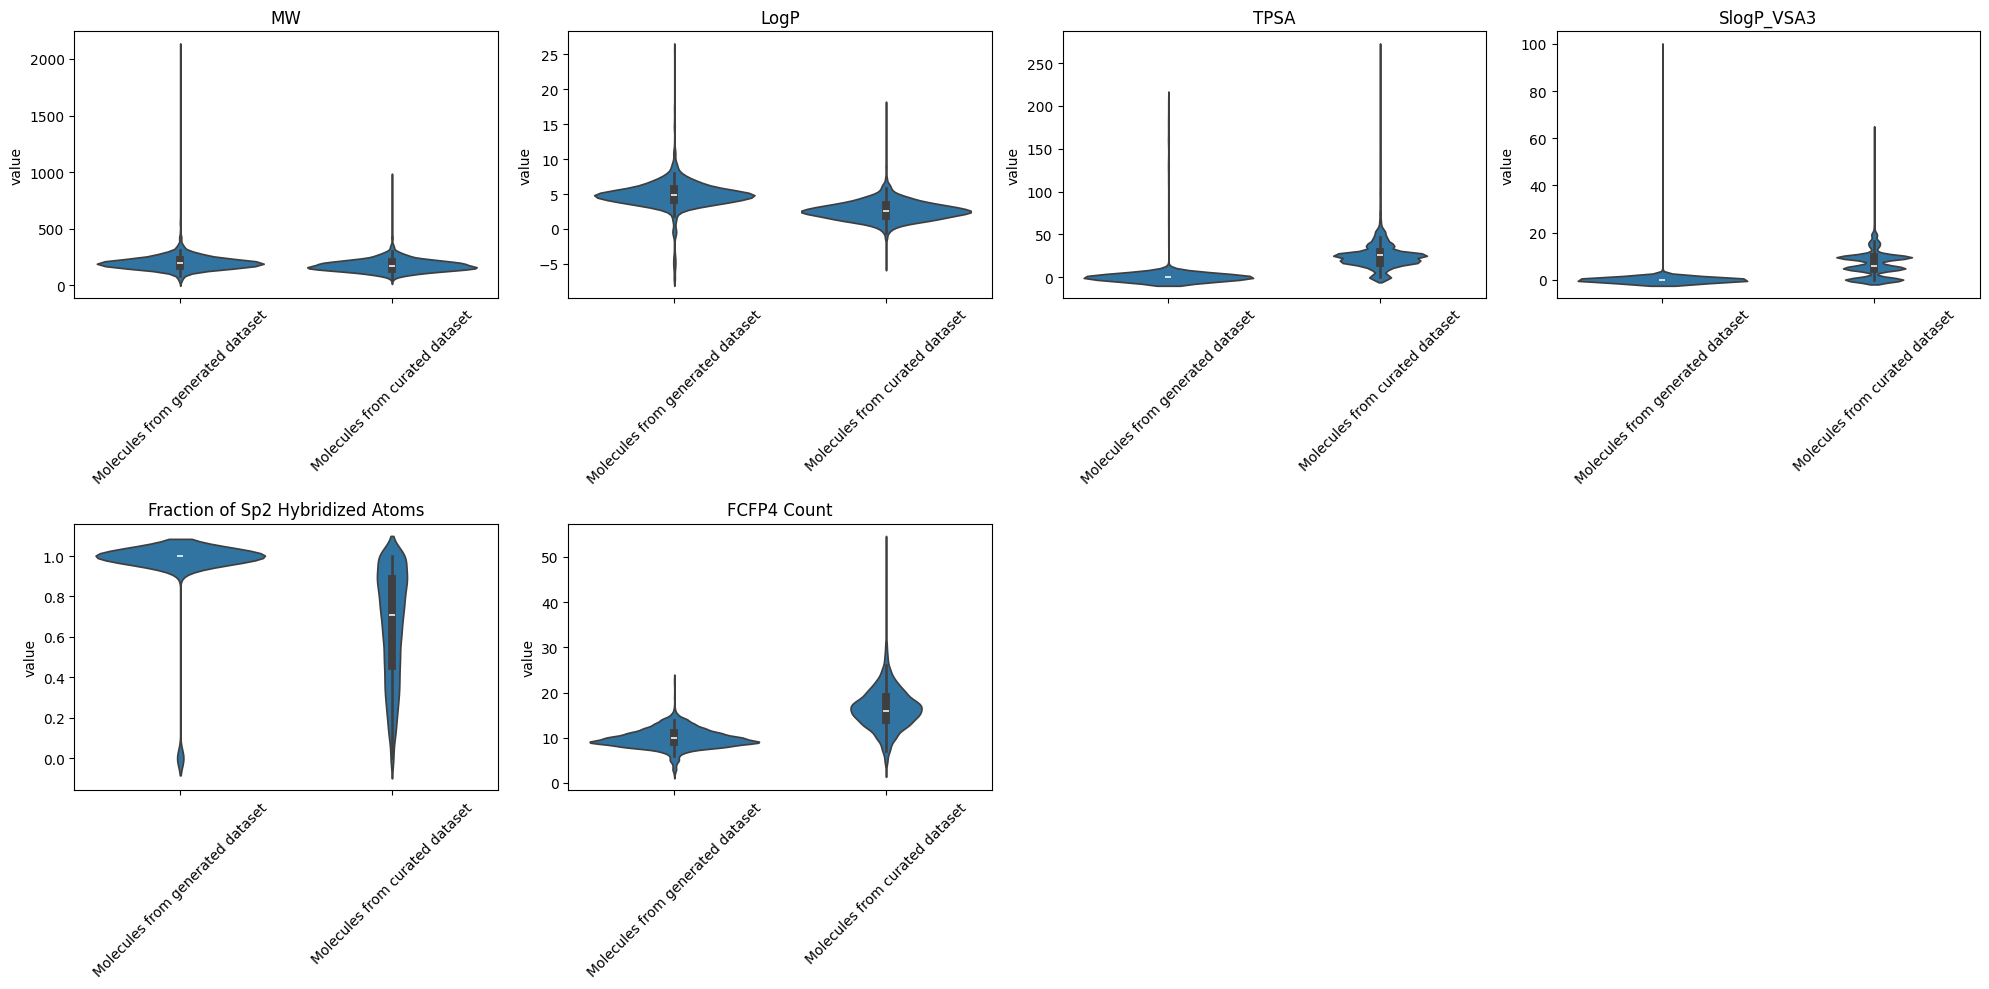

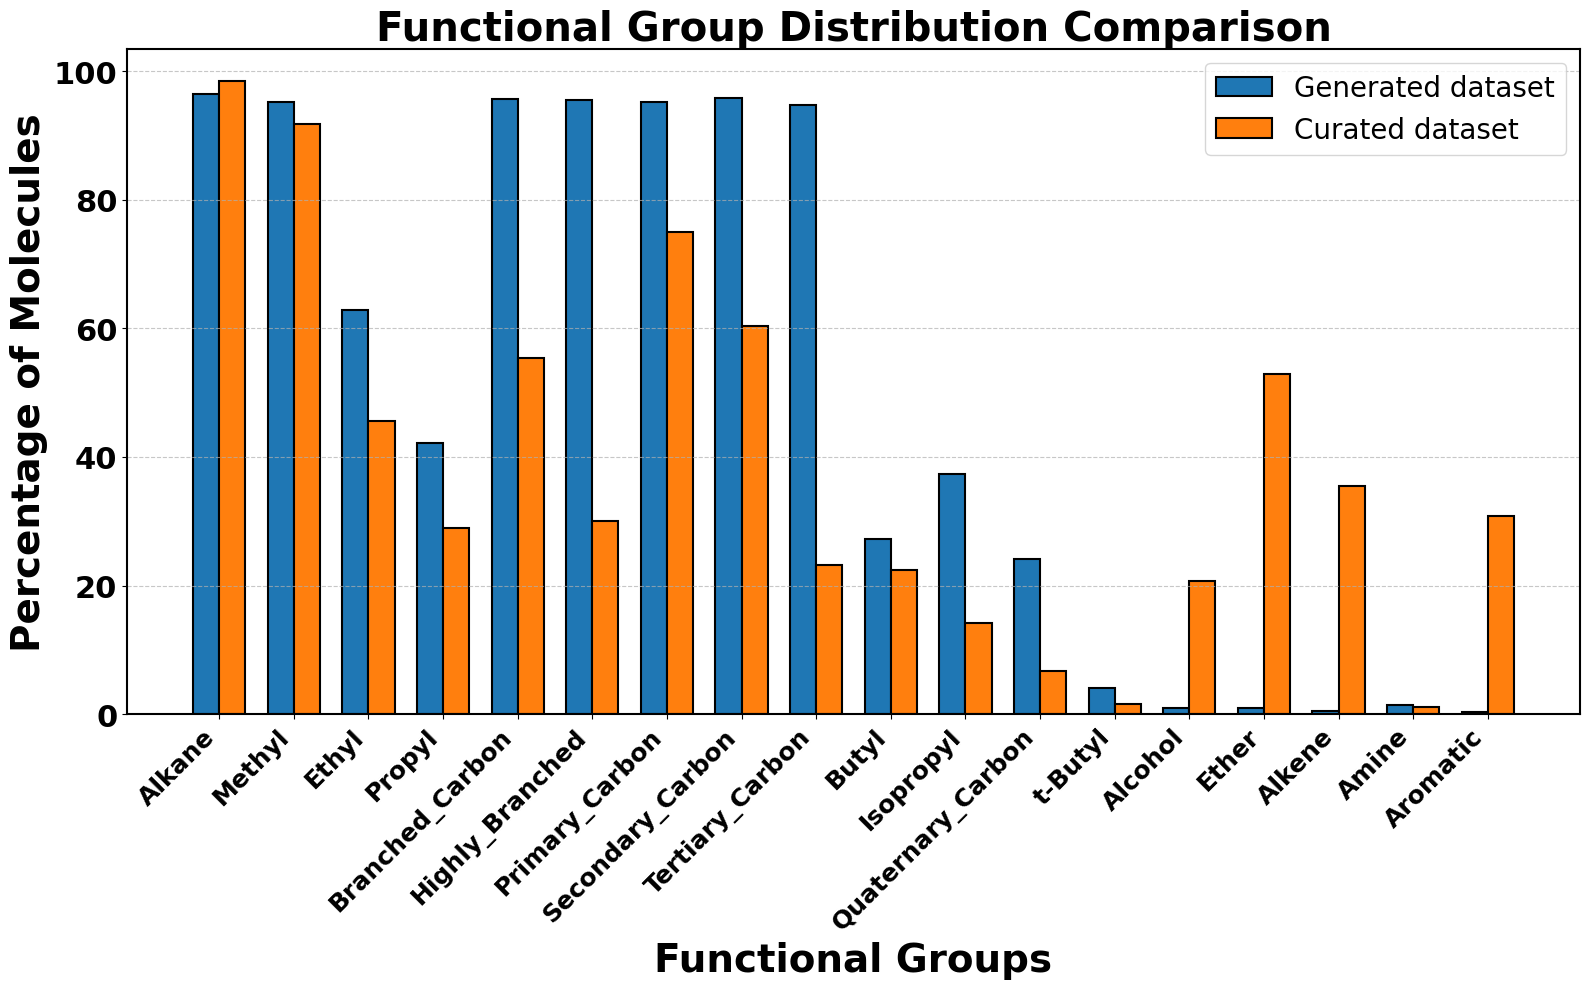


Statistical Test Results:
                                  KS_statistic      KS_pvalue  MW_statistic  \
MW                                    0.233936   8.531487e-59     4928069.5   
LogP                                  0.669568  1.916975e-321     6848414.0   
TPSA                                  0.903280   0.000000e+00      461420.5   
SlogP_VSA3                            0.742892  1.101766e-321     1023081.0   
Fraction of Sp2 Hybridized Atoms      0.831222  1.037538e-322     6975747.5   
FCFP4 Count                           0.721060  1.343859e-321      656178.5   

                                     MW_pvalue  T_statistic       T_pvalue  \
MW                                1.577679e-60    11.728074   7.124795e-31   
LogP                              0.000000e+00    40.486533  3.675252e-267   
TPSA                              0.000000e+00   -37.890764  1.344654e-243   
SlogP_VSA3                        0.000000e+00   -39.332357  2.446456e-268   
Fraction of Sp2 Hybridized At

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
from rdkit import RDLogger
import pandas as pd

df1 = pd.read_csv('../../data/ARGVA/filtered_generated_smiles.csv')
df2 = pd.read_csv('../../data/curated dataset/curated_GS_LF_merged_cleaned.csv')
# Disable RDKit warnings
RDLogger.DisableLog('rdApp.*')

def compare_extended_datasets(df1, df2, smiles_col1='SMILE', smiles_col2='nonStereoSMILES'):
    """Perform comprehensive comparison of two molecular datasets."""
    
    # Calculate extended molecular properties
    props1 = calculate_extended_properties(df1[smiles_col1])
    props2 = calculate_extended_properties(df2[smiles_col2])
    
    # Analyze extended functional groups
    fg1 = analyze_extended_functional_groups(df1[smiles_col1])
    fg2 = analyze_extended_functional_groups(df2[smiles_col2])
    
    # Statistical tests
    stats_results = calculate_statistical_tests(props1, props2)
    
    # Create visualizations
    prop_fig = plot_extended_analysis(props1, props2)
    
    # Functional group comparison plot
    plt.figure(figsize=(16, 10))
    groups = list(fg1.keys())
    x = np.arange(len(groups))
    width = 0.35
    
    bar1 = plt.bar(
        x - width / 2, 
        [fg1[g] for g in groups], 
        width, 
        label='Generated dataset', 
        edgecolor='black', 
        linewidth=1.5
    )
    bar2 = plt.bar(
        x + width / 2, 
        [fg2[g] for g in groups], 
        width, 
        label='Curated dataset', 
        edgecolor='black', 
        linewidth=1.5
    )
    
    plt.xlabel('Functional Groups', fontsize=28, fontweight='bold')
    plt.ylabel('Percentage of Molecules', fontsize=28, fontweight='bold')
    plt.title('Functional Group Distribution Comparison', fontsize=29, fontweight='bold')
    plt.xticks(x, groups, rotation=45, ha='right', fontsize=18, fontweight='bold')
    plt.yticks(fontsize=22, fontweight='bold')
    plt.legend(fontsize=20)
    
    # Bold grid and frame
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_linewidth(1.5)
    plt.gca().spines['right'].set_linewidth(1.5)
    plt.gca().spines['bottom'].set_linewidth(1.5)
    plt.gca().spines['left'].set_linewidth(1.5)

    # Save the figure
    output_folder = '../../figures/GAE/Group_analysis/'  # Specify the folder to save images
    os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist
    dpi_values = [300, 600, 1200]  # DPI levels
    for dpi in dpi_values:
        plt.savefig(f"{output_folder}Funct_Group_analysis_{dpi}dpi.png", dpi=dpi, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

    # Calculate summary statistics
    summary = {
        'Molecules from generated dataset': props1.describe(),
        'Molecules from curated dataset': props2.describe()
    }
    
    return summary, stats_results, prop_fig
# Run the extended analysis
summary, statistical_tests, figures = compare_extended_datasets(df1, df2)

# Display results
print("\nStatistical Test Results:")
print(statistical_tests)
directory = '../../data/ARGVA/KS_test'
file_path = os.path.join(directory, 'KS_properties.csv')

# Check if the directory exists, if not, create it
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the DataFrame to the CSV file
statistical_tests.to_csv(file_path)
plt.show()
